In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import time
from IPython.display import display

# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
print("Using GPU: ", tf.config.list_physical_devices('GPU'))

Using GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load and Preprocess the Fashion MNIST Dataset

In [4]:
# Load and preprocess the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Print the shapes of the dataset
print("Training set shape:", X_train_full.shape)
print("Test set shape:", X_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)


In [5]:
# Define class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Normalize pixel values to be between 0 and 1
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode the target variable
y_train_cat_full = to_categorical(y_train_full, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [6]:
# Split the training data into training and validation sets
X_train, X_val, y_train_cat, y_val_cat = train_test_split(
    X_train_full, y_train_cat_full, test_size=0.2, random_state=42
)

# Also split the original (non-categorical) labels - use the original array
_, _, y_train_orig, y_val_orig = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# Visualize the Dataset

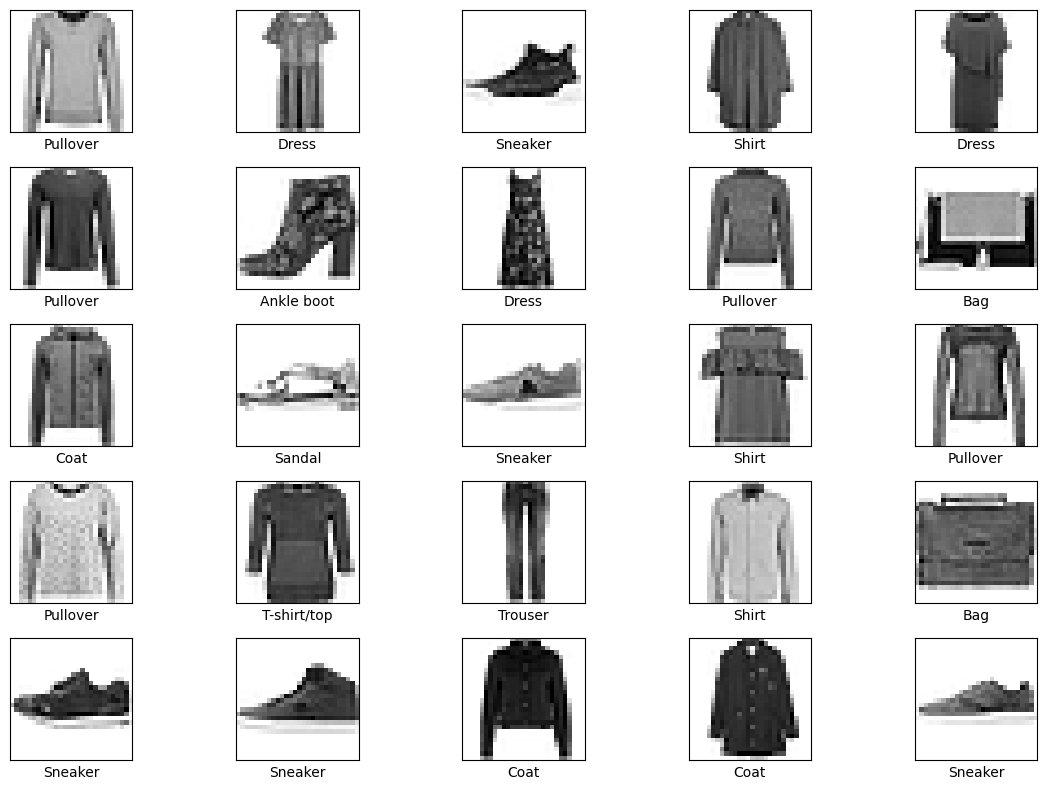

In [7]:
def visualize_fashion_mnist(X, y, class_names):
    """Visualize random samples from the Fashion MNIST dataset."""
    plt.figure(figsize=(12, 8))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        idx = np.random.randint(0, X.shape[0])
        plt.imshow(X[idx], cmap=plt.cm.binary)

        # Check if y is one-hot encoded (2D) or original labels (1D)
        if len(y.shape) > 1:
            # For one-hot encoded labels
            label_idx = np.argmax(y[idx])
        else:
            # For integer labels
            label_idx = y[idx]

        plt.xlabel(class_names[label_idx])

    plt.tight_layout()
    plt.show()

# Visualize random samples from the training set
visualize_fashion_mnist(X_train, y_train_orig, class_names)

T-shirt/top: 4798 samples
Trouser: 4781 samples
Pullover: 4795 samples
Dress: 4816 samples
Coat: 4798 samples
Sandal: 4789 samples
Shirt: 4782 samples
Sneaker: 4841 samples
Bag: 4803 samples
Ankle boot: 4797 samples


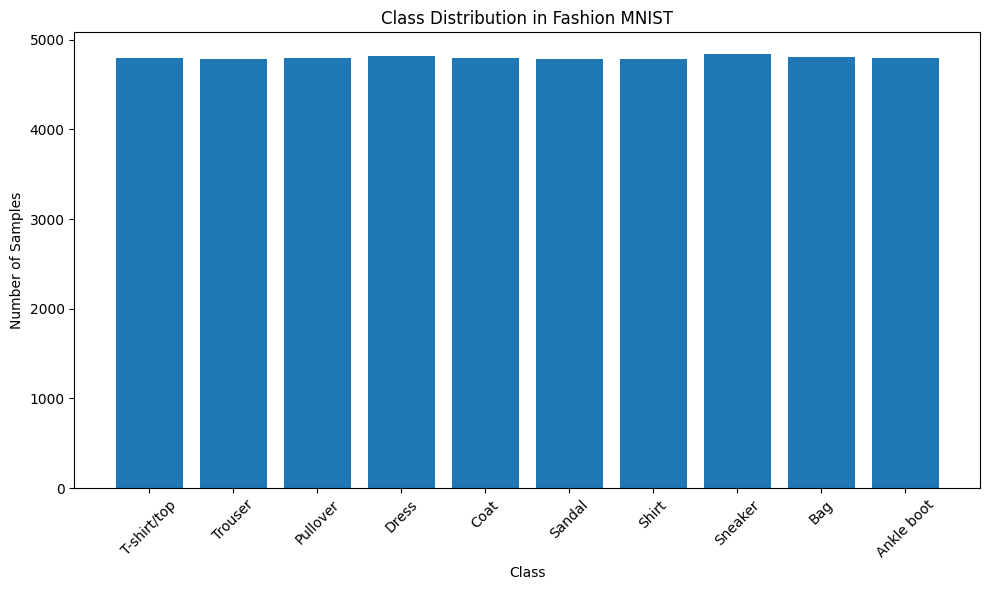

In [8]:
# For the class distribution, use the original labels
plt.figure(figsize=(10, 6))
counts = np.bincount(y_train_orig)  # Use y_train_orig instead of y_train
for i in range(len(class_names)):
    print(f"{class_names[i]}: {counts[i]} samples")

plt.bar(class_names, counts)
plt.title('Class Distribution in Fashion MNIST')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Creating a Base Model Architecture

In [9]:
def create_rnn_model(rnn_type='simple', units=128, dropout_rate=0.2, learning_rate=0.001):
    """
    Create a RNN model with the specified architecture.

    Parameters:
    - rnn_type: 'simple', 'lstm', or 'gru'
    - units: Number of units in the RNN layer
    - dropout_rate: Dropout rate for regularization
    - learning_rate: Learning rate for the Adam optimizer

    Returns:
    - model: Compiled Keras model
    """
    model = Sequential()

    # Add the appropriate RNN layer
    if rnn_type == 'simple':
        model.add(SimpleRNN(units=units, input_shape=(28, 28), return_sequences=False))
    elif rnn_type == 'lstm':
        model.add(LSTM(units=units, input_shape=(28, 28), return_sequences=False))
    elif rnn_type == 'gru':
        model.add(GRU(units=units, input_shape=(28, 28), return_sequences=False))
    else:
        raise ValueError("rnn_type must be one of 'simple', 'lstm', or 'gru'")

    # Add dropout for regularization
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [10]:
def get_callbacks():
    """Create callbacks for model training."""
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    return [early_stopping, reduce_lr]

In [11]:
def train_model(model, X_train, y_train_cat, X_val, y_val_cat, epochs=20, batch_size=128):
    """Train the model and return history and training time."""
    callbacks = get_callbacks()

    start_time = time.time()

    history = model.fit(
        X_train, y_train_cat,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val_cat),
        callbacks=callbacks,
        verbose=1
    )

    training_time = time.time() - start_time

    return model, history, training_time

In [12]:
def evaluate_model(model, X_test, y_test_cat, y_test):
    """Evaluate the model on test data and return metrics."""
    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)

    # Make predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=class_names)

    return test_loss, test_acc, y_pred, cm, report

In [13]:
def plot_training_history(history, title):
    """Plot the training and validation accuracy and loss."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'{title} - Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

In [14]:
def plot_confusion_matrix(cm, class_names, title):
    """Plot the confusion matrix."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {title}')
    plt.tight_layout()
    plt.show()

In [15]:
def visualize_incorrect_predictions(X_test, y_test, y_pred, class_names, title, n=25):
    """Visualize random incorrect predictions."""
    incorrect_indices = np.where(y_test != y_pred)[0]

    if len(incorrect_indices) == 0:
        print("No incorrect predictions found.")
        return

    # Randomly select some incorrect predictions
    n = min(n, len(incorrect_indices))
    random_indices = np.random.choice(incorrect_indices, n, replace=False)

    plt.figure(figsize=(12, 10))
    for i, idx in enumerate(random_indices):
        if i >= 25:  # Limit to 25 examples
            break

        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_test[idx], cmap=plt.cm.binary)
        plt.xlabel(f'True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}', fontsize=8)

    plt.suptitle(f'Incorrect Predictions - {title}')
    plt.tight_layout()
    plt.show()

In [16]:
print("Training Simple RNN model...")
rnn_model = create_rnn_model(rnn_type='simple', units=128, dropout_rate=0.2)
rnn_model.summary()

Training Simple RNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386 (83.54 KB)

 Trainable params: 21,386 (83.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the model
rnn_model, rnn_history, rnn_time = train_model(
    rnn_model, X_train, y_train_cat, X_val, y_val_cat, epochs=20
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6308 - loss: 1.0271 - val_accuracy: 0.7892 - val_loss: 0.5780 - learning_rate: 0.0010
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7948 - loss: 0.5783 - val_accuracy: 0.8195 - val_loss: 0.5068 - learning_rate: 0.0010
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8178 - loss: 0.5185 - val_accuracy: 0.8267 - val_loss: 0.4853 - learning_rate: 0.0010
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8297 - loss: 0.4826 - val_accuracy: 0.8428 - val_loss: 0.4368 - learning_rate: 0.0010
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8388 - loss: 0.4555 - val_accuracy: 0.8405 - val_loss: 0.4444 - learning_rate: 0.0010
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8412 - loss: 0.4444 - val_accuracy: 0.8445 - val_loss: 0.4282 - learning_rate: 0.0010
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8468 - loss: 0.4289 - 

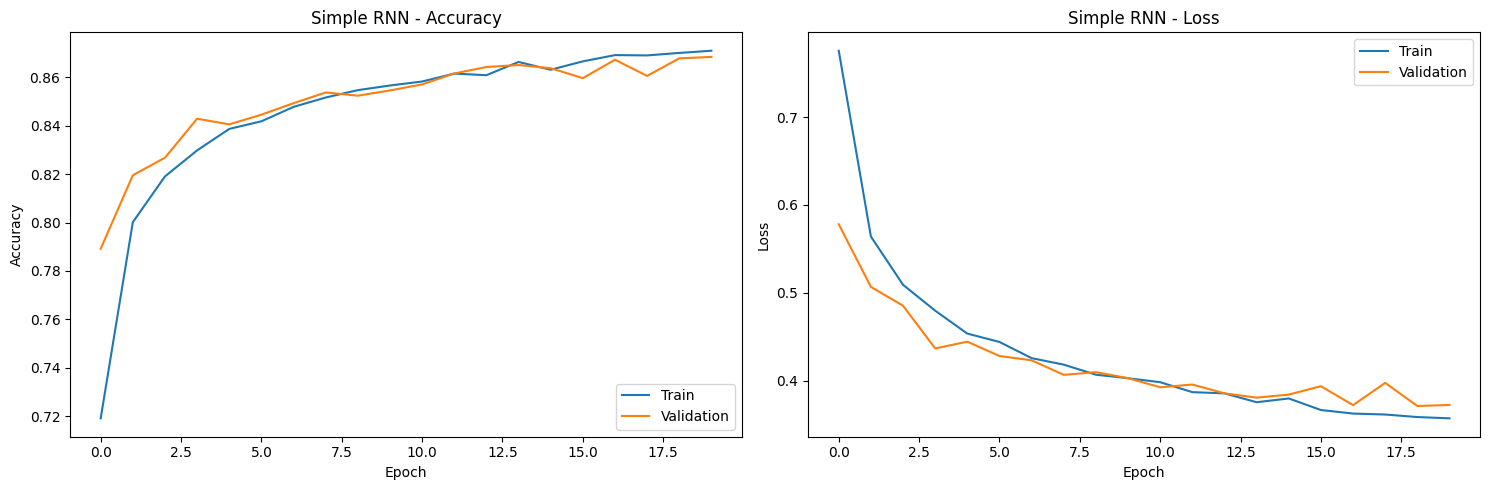

In [18]:
# Plot training history
plot_training_history(rnn_history, 'Simple RNN')

In [19]:
# Evaluate the model
rnn_test_loss, rnn_test_acc, rnn_preds, rnn_cm, rnn_report = evaluate_model(
    rnn_model, X_test, y_test_cat, y_test
)

print(f"\nSimple RNN Test Accuracy: {rnn_test_acc:.4f}")
print(f"Simple RNN Test Loss: {rnn_test_loss:.4f}")
print(f"Simple RNN Training Time: {rnn_time:.2f} seconds")

print("\nClassification Report - Simple RNN:")
print(rnn_report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Simple RNN Test Accuracy: 0.8614
Simple RNN Test Loss: 0.3897
Simple RNN Training Time: 52.66 seconds

Classification Report - Simple RNN:
              precision    recall  f1-score   support

 T-shirt/top       0.76      0.84      0.80      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.77      0.79      0.78      1000
       Dress       0.85      0.89      0.87      1000
        Coat       0.76      0.80      0.78      1000
      Sandal       0.95      0.95      0.95      1000
       Shirt       0.69      0.57      0.62      1000
     Sneaker       0.93      0.94      0.94      1000
         Bag       0.98      0.93      0.95      1000
  Ankle boot       0.94      0.95      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



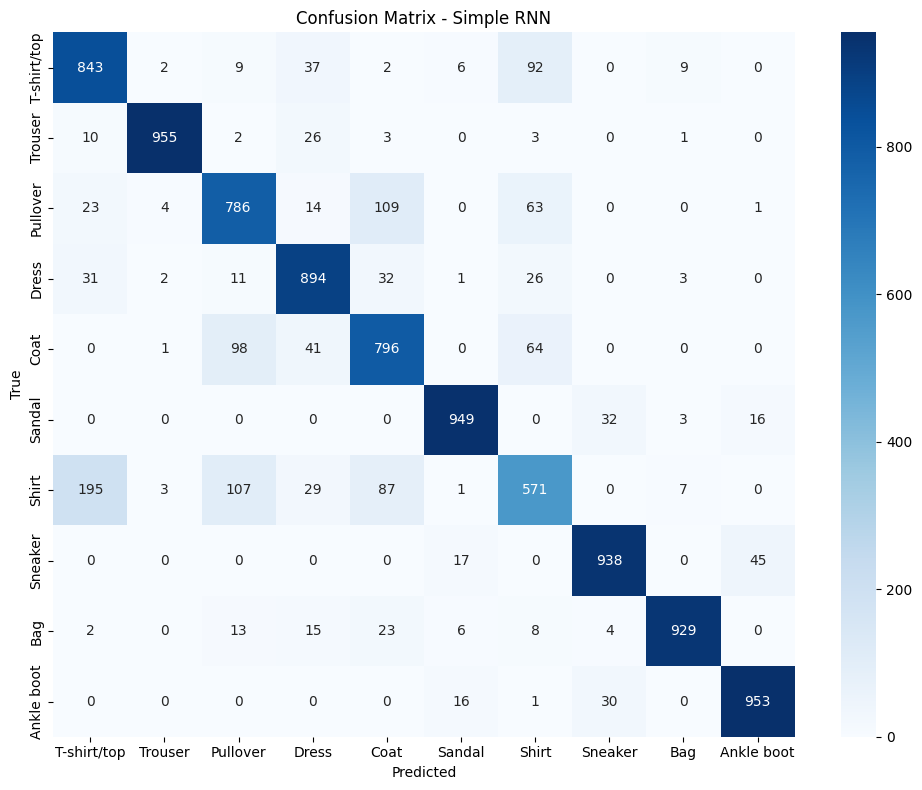

In [20]:
# Plot confusion matrix
plot_confusion_matrix(rnn_cm, class_names, 'Simple RNN')

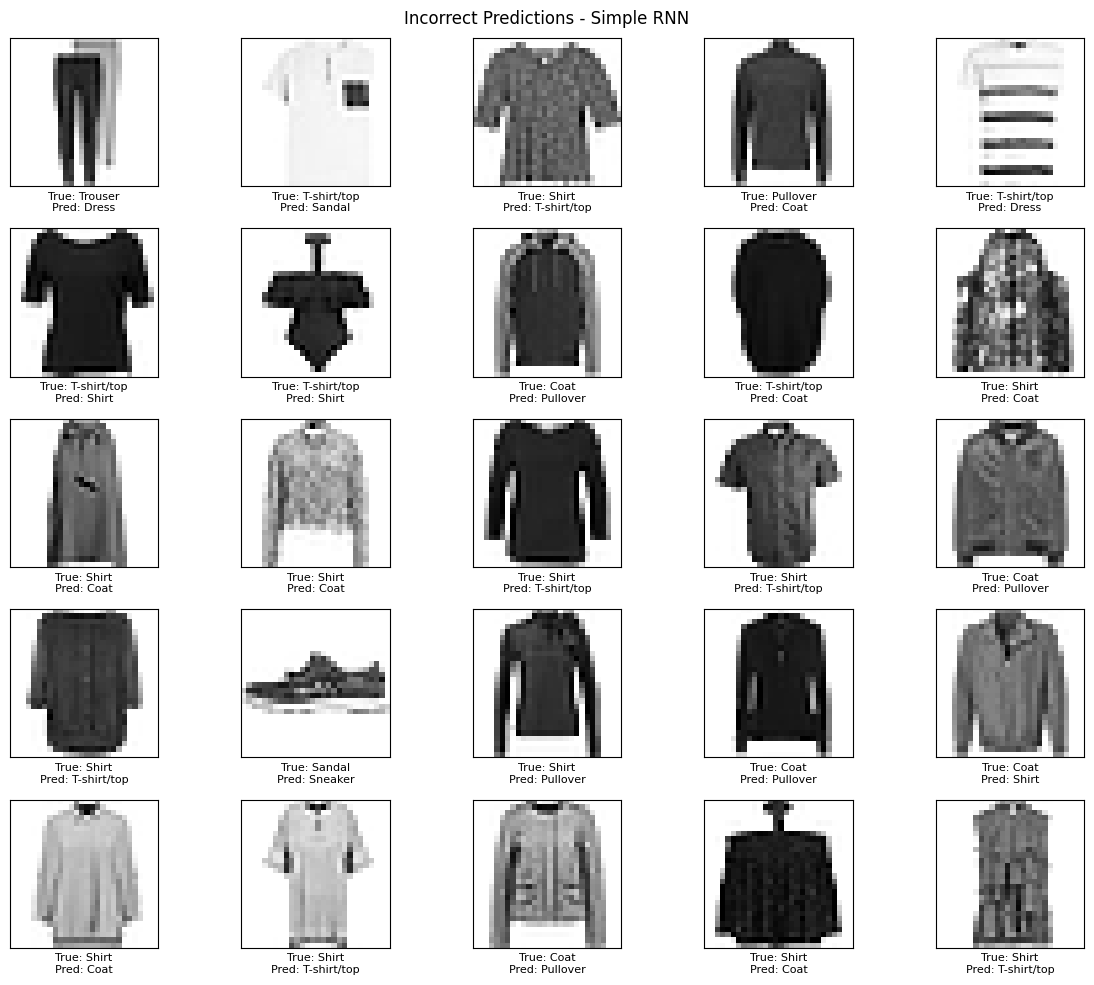

In [21]:
# Visualize incorrect predictions
visualize_incorrect_predictions(X_test, y_test, rnn_preds, class_names, 'Simple RNN')

# Train and Evaluate LSTM Model

In [22]:
# Create an LSTM model
print("Training LSTM model...")
lstm_model = create_rnn_model(rnn_type='lstm', units=128, dropout_rate=0.2)
lstm_model.summary()

Training LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,674 (319.04 KB)

 Trainable params: 81,674 (319.04 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the model
lstm_model, lstm_history, lstm_time = train_model(
    lstm_model, X_train, y_train_cat, X_val, y_val_cat, epochs=20
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6269 - loss: 1.0330 - val_accuracy: 0.8055 - val_loss: 0.5302 - learning_rate: 0.0010
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8168 - loss: 0.5026 - val_accuracy: 0.8232 - val_loss: 0.4763 - learning_rate: 0.0010
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8384 - loss: 0.4412 - val_accuracy: 0.8540 - val_loss: 0.4010 - learning_rate: 0.0010
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8553 - loss: 0.3999 - val_accuracy: 0.8606 - val_loss: 0.3782 - learning_rate: 0.0010
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8621 - loss: 0.3761 - val_accuracy: 0.8660 - val_loss: 0.3637 - learning_rate: 0.0010
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8665 - loss: 0.3582 - val_accuracy: 0.8685 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8755 - loss: 0.3403 

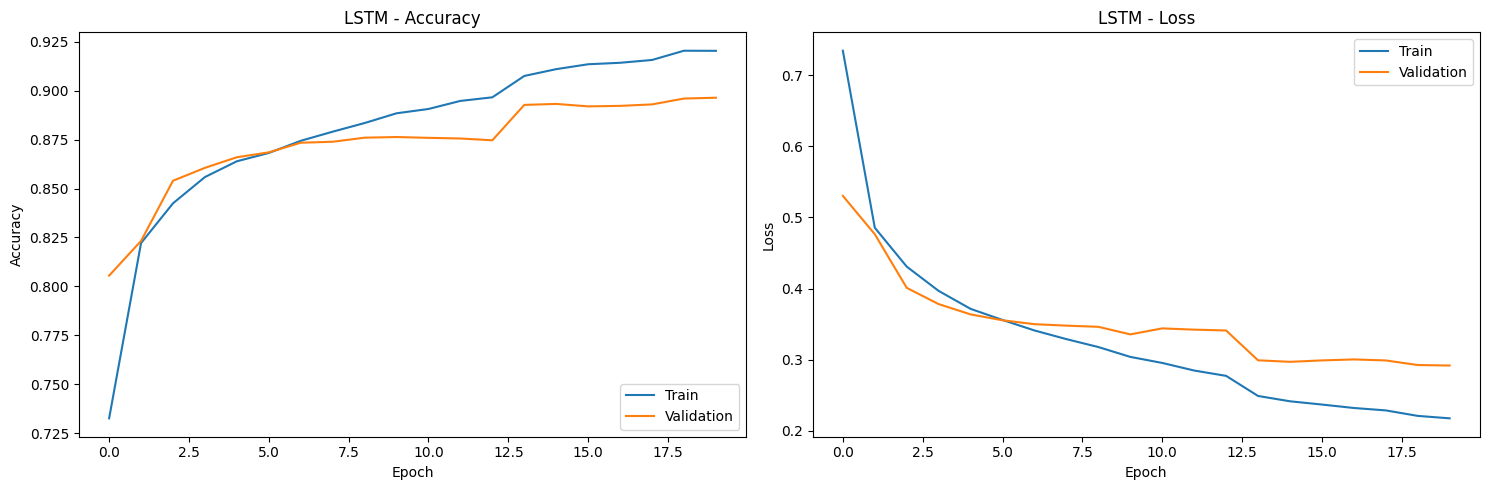

In [24]:
# Plot training history
plot_training_history(lstm_history, 'LSTM')

In [25]:
# Evaluate the model
lstm_test_loss, lstm_test_acc, lstm_preds, lstm_cm, lstm_report = evaluate_model(
    lstm_model, X_test, y_test_cat, y_test
)

print(f"\nLSTM Test Accuracy: {lstm_test_acc:.4f}")
print(f"LSTM Test Loss: {lstm_test_loss:.4f}")
print(f"LSTM Training Time: {lstm_time:.2f} seconds")

print("\nClassification Report - LSTM:")
print(lstm_report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

LSTM Test Accuracy: 0.8888
LSTM Test Loss: 0.3088
LSTM Training Time: 58.31 seconds

Classification Report - LSTM:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.84      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.80      0.80      0.80      1000
       Dress       0.88      0.90      0.89      1000
        Coat       0.81      0.81      0.81      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.73      0.71      0.72      1000
     Sneaker       0.95      0.95      0.95      1000
         Bag       0.97      0.98      0.97      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



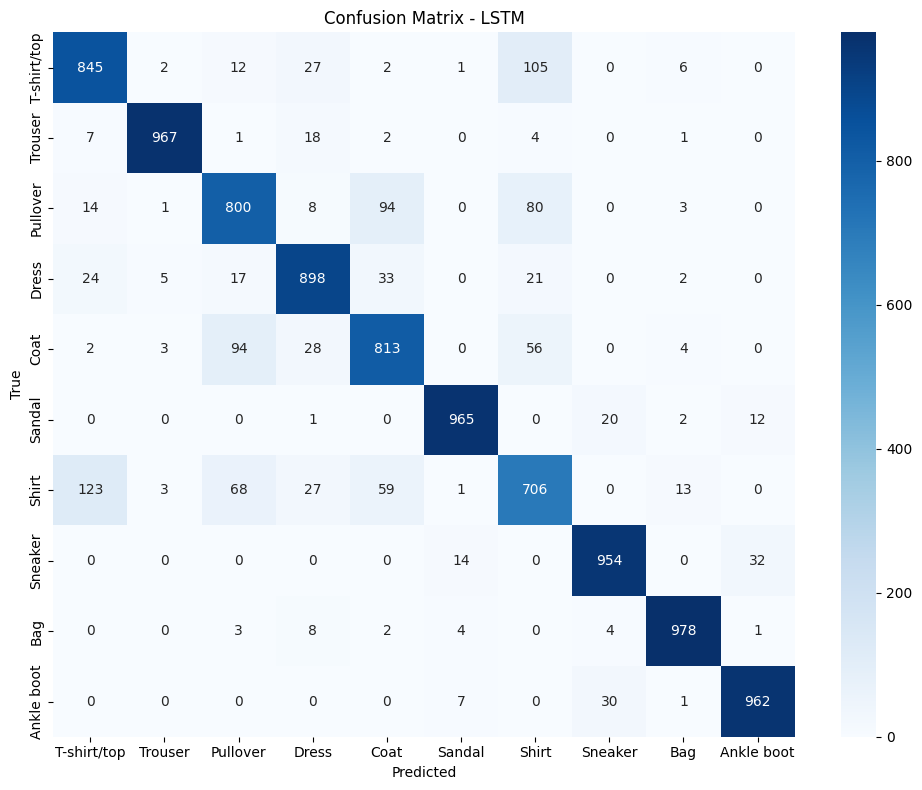

In [26]:
# Plot confusion matrix
plot_confusion_matrix(lstm_cm, class_names, 'LSTM')

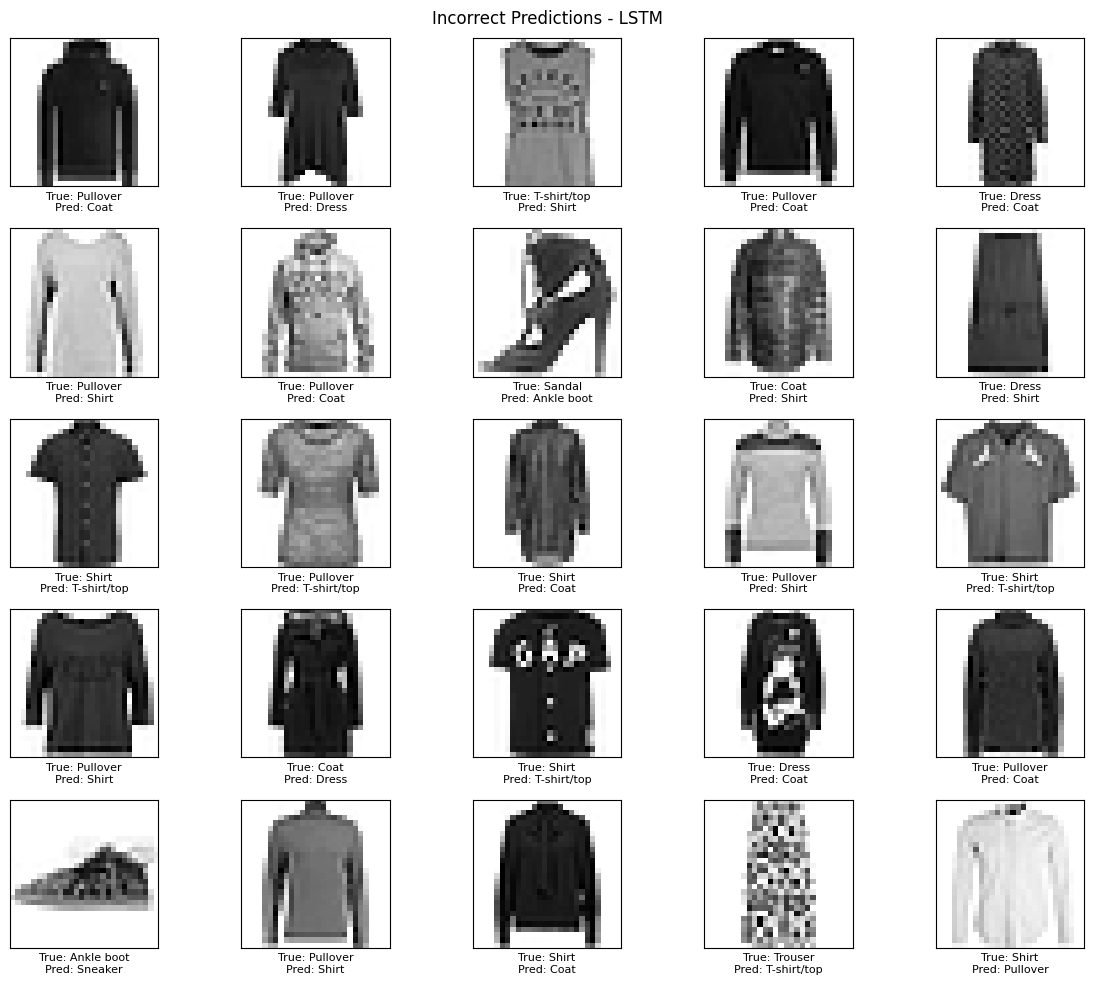

In [27]:
# Visualize incorrect predictions
visualize_incorrect_predictions(X_test, y_test, lstm_preds, class_names, 'LSTM')

# Train and Evaluate GRU Model

In [28]:
# Create a GRU model
print("Training GRU model...")
gru_model = create_rnn_model(rnn_type='gru', units=128, dropout_rate=0.2)
gru_model.summary()

Training GRU model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        60,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,962 (242.04 KB)

 Trainable params: 61,962 (242.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5524 - loss: 1.2222 - val_accuracy: 0.8006 - val_loss: 0.5496 - learning_rate: 0.0010
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8058 - loss: 0.5262 - val_accuracy: 0.8420 - val_loss: 0.4344 - learning_rate: 0.0010
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8389 - loss: 0.4383 - val_accuracy: 0.8528 - val_loss: 0.3982 - learning_rate: 0.0010
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8583 - loss: 0.3919 - val_accuracy: 0.8599 - val_loss: 0.3803 - learning_rate: 0.0010
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8667 - loss: 0.3690 - val_accuracy: 0.8677 - val_loss: 0.3545 - learning_rate: 0.0010
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8738 - loss: 0.3460 - val_accuracy: 0.8696 - val_loss: 0.3500 - learning_rate: 0.0010
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8791 - loss: 0.3311 -

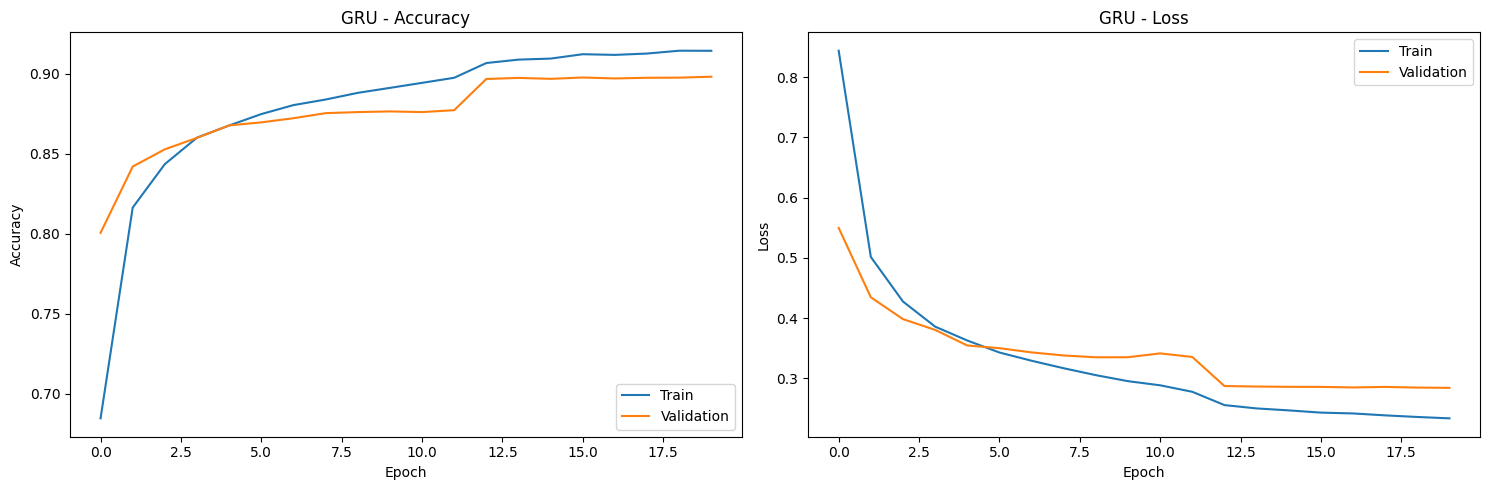

In [29]:
# Train the model
gru_model, gru_history, gru_time = train_model(
    gru_model, X_train, y_train_cat, X_val, y_val_cat, epochs=20
)

# Plot training history
plot_training_history(gru_history, 'GRU')

In [30]:
# Evaluate the model
gru_test_loss, gru_test_acc, gru_preds, gru_cm, gru_report = evaluate_model(
    gru_model, X_test, y_test_cat, y_test
)

print(f"\nGRU Test Accuracy: {gru_test_acc:.4f}")
print(f"GRU Test Loss: {gru_test_loss:.4f}")
print(f"GRU Training Time: {gru_time:.2f} seconds")

print("\nClassification Report - GRU:")
print(gru_report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

GRU Test Accuracy: 0.8936
GRU Test Loss: 0.3022
GRU Training Time: 65.58 seconds

Classification Report - GRU:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.83      0.84      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.83      0.79      0.81      1000
       Dress       0.90      0.90      0.90      1000
        Coat       0.80      0.84      0.82      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.71      0.72      0.71      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.97      0.98      0.97      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



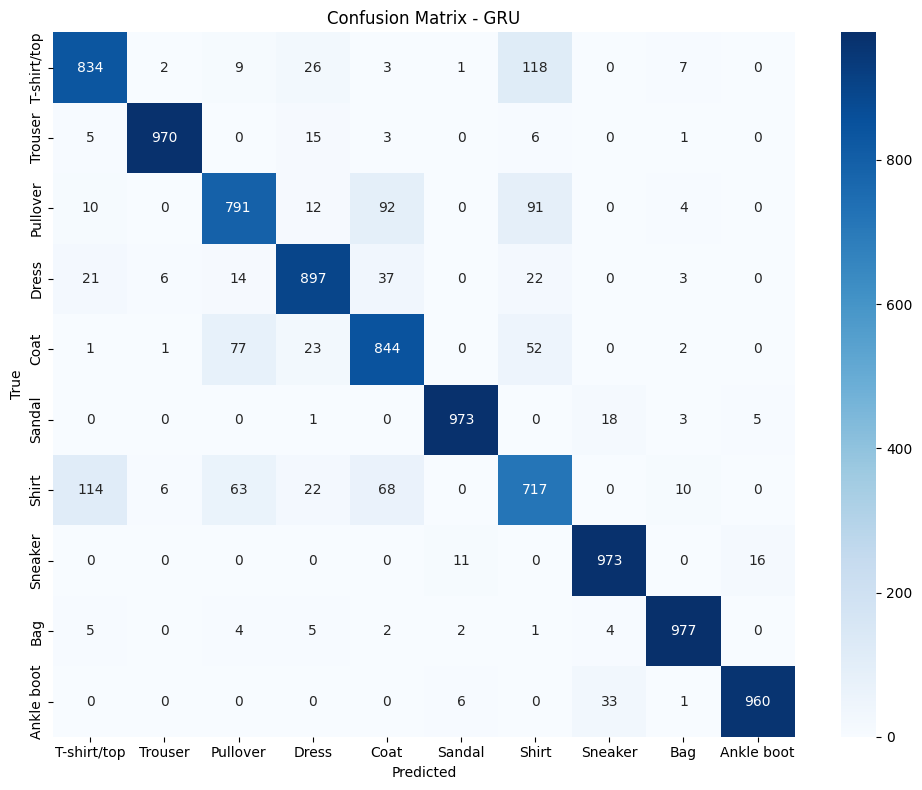

In [31]:
# Plot confusion matrix
plot_confusion_matrix(gru_cm, class_names, 'GRU')

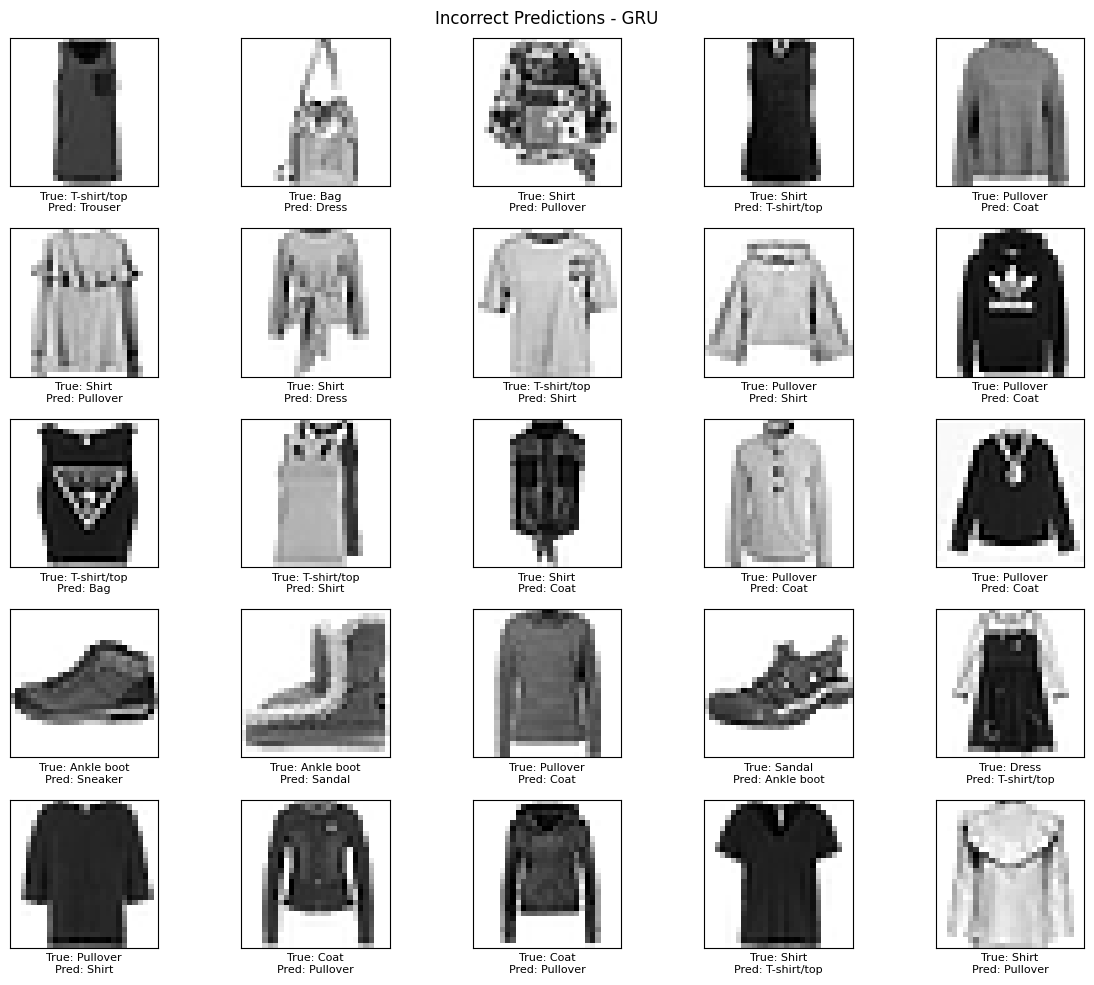

In [32]:
# Visualize incorrect predictions
visualize_incorrect_predictions(X_test, y_test, gru_preds, class_names, 'GRU')

# Model Comparison

In [33]:
# Compile all results
models = ['Simple RNN', 'LSTM', 'GRU']
accuracies = [rnn_test_acc, lstm_test_acc, gru_test_acc]
losses = [rnn_test_loss, lstm_test_loss, gru_test_loss]
times = [rnn_time, lstm_time, gru_time]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Loss': losses,
    'Training Time (s)': times
})

print("Model Comparison:")
display(comparison_df)

Model Comparison:


,Model,Accuracy,Loss,Training Time (s)
0,Simple RNN,0.8614,0.389673,52.662835
1,LSTM,0.8888,0.308783,58.305866
2,GRU,0.8936,0.302179,65.580606


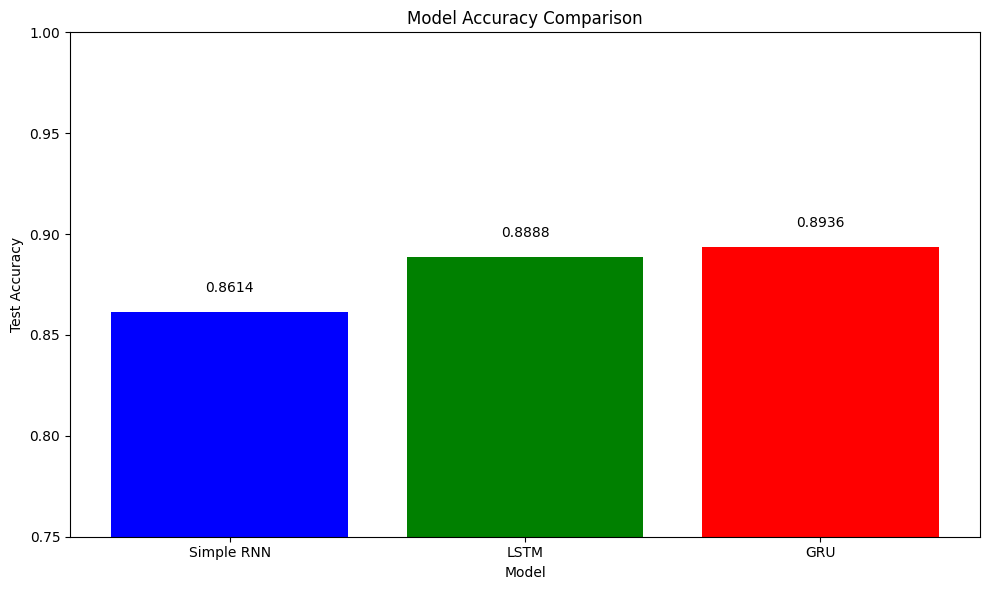

In [34]:
# Plot accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0.75, 1.0)  # Adjust as needed
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

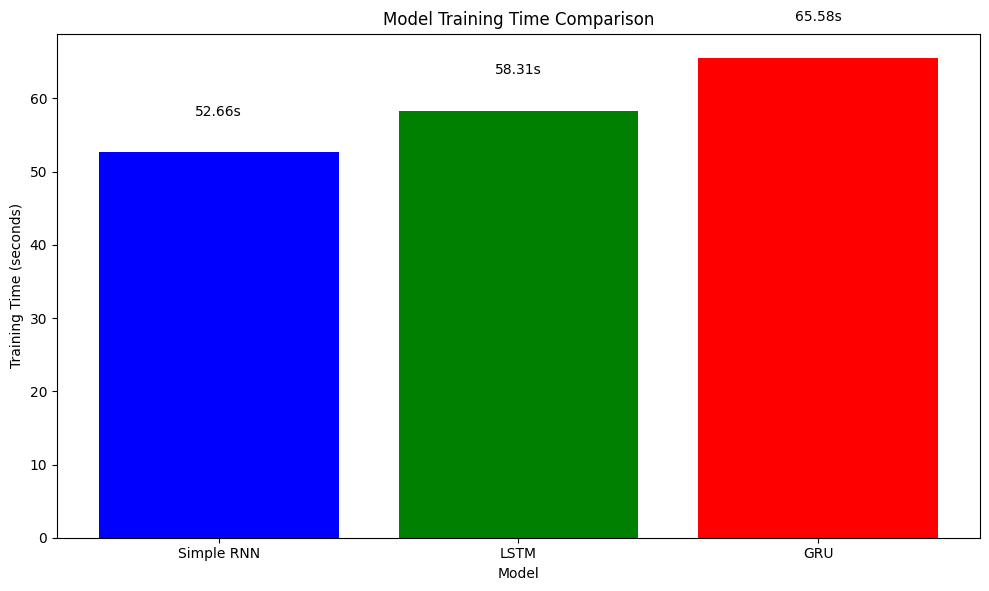

In [35]:
# Plot training time comparison
plt.figure(figsize=(10, 6))
plt.bar(models, times, color=['blue', 'green', 'red'])
plt.title('Model Training Time Comparison')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
for i, t in enumerate(times):
    plt.text(i, t + 5, f'{t:.2f}s', ha='center')
plt.tight_layout()
plt.show()

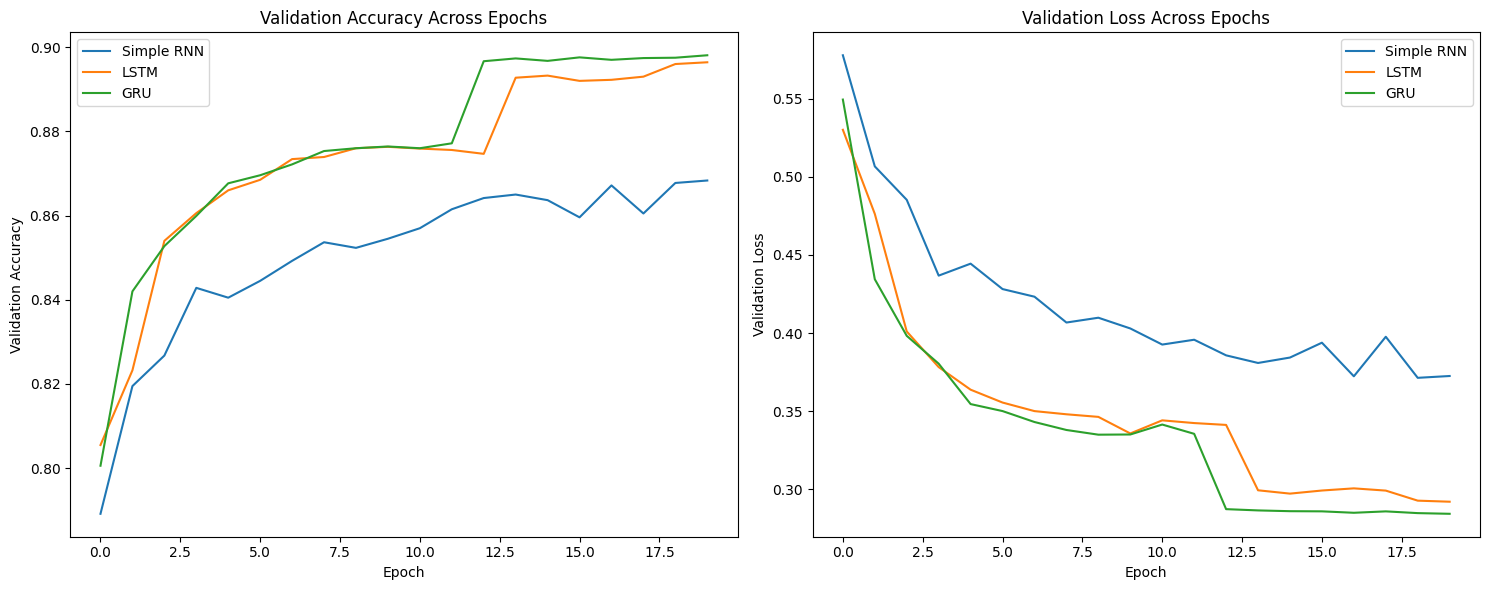

In [36]:
# Plot learning curves comparison
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['val_accuracy'], label='Simple RNN')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM')
plt.plot(gru_history.history['val_accuracy'], label='GRU')
plt.title('Validation Accuracy Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['val_loss'], label='Simple RNN')
plt.plot(lstm_history.history['val_loss'], label='LSTM')
plt.plot(gru_history.history['val_loss'], label='GRU')
plt.title('Validation Loss Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Hyperparameter Tuning

In [37]:
def hyperparameter_tuning(rnn_type, param_grid):
    """
    Perform hyperparameter tuning for the specified RNN type.

    Parameters:
    - rnn_type: 'simple', 'lstm', or 'gru'
    - param_grid: Dictionary of hyperparameters to tune

    Returns:
    - results_df: DataFrame with tuning results
    - best_model: Best model found
    """
    results = []
    best_val_acc = 0
    best_model = None

    # Number of units
    for units in param_grid['units']:
        # Dropout rate
        for dropout_rate in param_grid['dropout_rate']:
            # Learning rate
            for learning_rate in param_grid['learning_rate']:
                # Create and train the model
                print(f"\nTraining {rnn_type.upper()} with units={units}, dropout={dropout_rate}, lr={learning_rate}")

                model = create_rnn_model(
                    rnn_type=rnn_type,
                    units=units,
                    dropout_rate=dropout_rate,
                    learning_rate=learning_rate
                )

                # Use early stopping to prevent overfitting
                callbacks = get_callbacks()

                start_time = time.time()
                history = model.fit(
                    X_train, y_train_cat,
                    epochs=15,  # Reduced for hyperparameter tuning
                    batch_size=128,
                    validation_data=(X_val, y_val_cat),
                    callbacks=callbacks,
                    verbose=0
                )
                training_time = time.time() - start_time

                # Evaluate on validation set
                val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)

                # Save results
                results.append({
                    'units': units,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate,
                    'val_accuracy': val_acc,
                    'val_loss': val_loss,
                    'training_time': training_time,
                    'epochs_trained': len(history.history['loss'])
                })

                print(f"Validation accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}, Time: {training_time:.2f}s")

                # Update best model if needed
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model = model

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df, best_model

In [38]:
# Define hyperparameter grid
param_grid = {
    'units': [64, 128, 256],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0005]
}

In [39]:
# Hyperparameter tuning for Simple RNN
print("Hyperparameter tuning for Simple RNN...")
rnn_results, best_rnn_model = hyperparameter_tuning('simple', param_grid)

# Hyperparameter tuning for LSTM
print("\nHyperparameter tuning for LSTM...")
lstm_results, best_lstm_model = hyperparameter_tuning('lstm', param_grid)

# Hyperparameter tuning for GRU
print("\nHyperparameter tuning for GRU...")
gru_results, best_gru_model = hyperparameter_tuning('gru', param_grid)

Hyperparameter tuning for Simple RNN...

Training SIMPLE with units=64, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Restoring model weights from the end of the best epoch: 15.
Validation accuracy: 0.8510, Loss: 0.4109, Time: 35.08s

Training SIMPLE with units=64, dropout=0.2, lr=0.0005
Restoring model weights from the end of the best epoch: 15.
Validation accuracy: 0.8371, Loss: 0.4513, Time: 34.28s

Training SIMPLE with units=64, dropout=0.3, lr=0.001
Restoring model weights from the end of the best epoch: 13.
Validation accuracy: 0.8466, Loss: 0.4375, Time: 33.82s

Training SIMPLE with units=64, dropout=0.3, lr=0.0005
Restoring model weights from the end of the best epoch: 14.
Validation accuracy: 0.8378, Loss: 0.4531, Time: 34.83s

Training SIMPLE with units=64, dropout=0.4, lr=0.001
Restoring model weights from the end of the best epoch: 13.
Validation accuracy: 0.8489, Loss: 0.4303, Time: 35.58s

Training SIMPLE with units=64, dropout=0.4, lr=0.0005
Restoring model weights from the end of the best epoch: 15.
Validation accuracy: 0.8418, Loss: 0.4475, Time: 36.44s

Training SIMPLE with units=128

In [40]:
# Display the best configurations
print("\nBest Simple RNN Configuration:")
display(rnn_results.sort_values('val_accuracy', ascending=False).head(1))


Best Simple RNN Configuration:


,units,dropout_rate,learning_rate,val_accuracy,val_loss,training_time,epochs_trained
17,256,0.4,0.0005,0.8885,0.314262,38.727191,15


In [41]:
print("\nBest LSTM Configuration:")
display(lstm_results.sort_values('val_accuracy', ascending=False).head(1))


Best LSTM Configuration:


,units,dropout_rate,learning_rate,val_accuracy,val_loss,training_time,epochs_trained
6,128,0.2,0.001,0.893917,0.297868,42.416846,15


In [42]:
print("\nBest GRU Configuration:")
display(gru_results.sort_values('val_accuracy', ascending=False).head(1))


Best GRU Configuration:


,units,dropout_rate,learning_rate,val_accuracy,val_loss,training_time,epochs_trained
14,256,0.3,0.001,0.905083,0.271479,49.553358,15


In [43]:
# Visualize hyperparameter tuning results
def plot_hyperparameter_results(results_df, title):
    """Plot the impact of hyperparameters on validation accuracy."""
    plt.figure(figsize=(18, 5))

    # Plot effect of units
    plt.subplot(1, 3, 1)
    sns.boxplot(x='units', y='val_accuracy', data=results_df)
    plt.title(f'{title} - Impact of Units')
    plt.xlabel('Number of Units')
    plt.ylabel('Validation Accuracy')

    # Plot effect of dropout rate
    plt.subplot(1, 3, 2)
    sns.boxplot(x='dropout_rate', y='val_accuracy', data=results_df)
    plt.title(f'{title} - Impact of Dropout Rate')
    plt.xlabel('Dropout Rate')
    plt.ylabel('Validation Accuracy')

    # Plot effect of learning rate
    plt.subplot(1, 3, 3)
    sns.boxplot(x='learning_rate', y='val_accuracy', data=results_df)
    plt.title(f'{title} - Impact of Learning Rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Validation Accuracy')

    plt.tight_layout()
    plt.show()

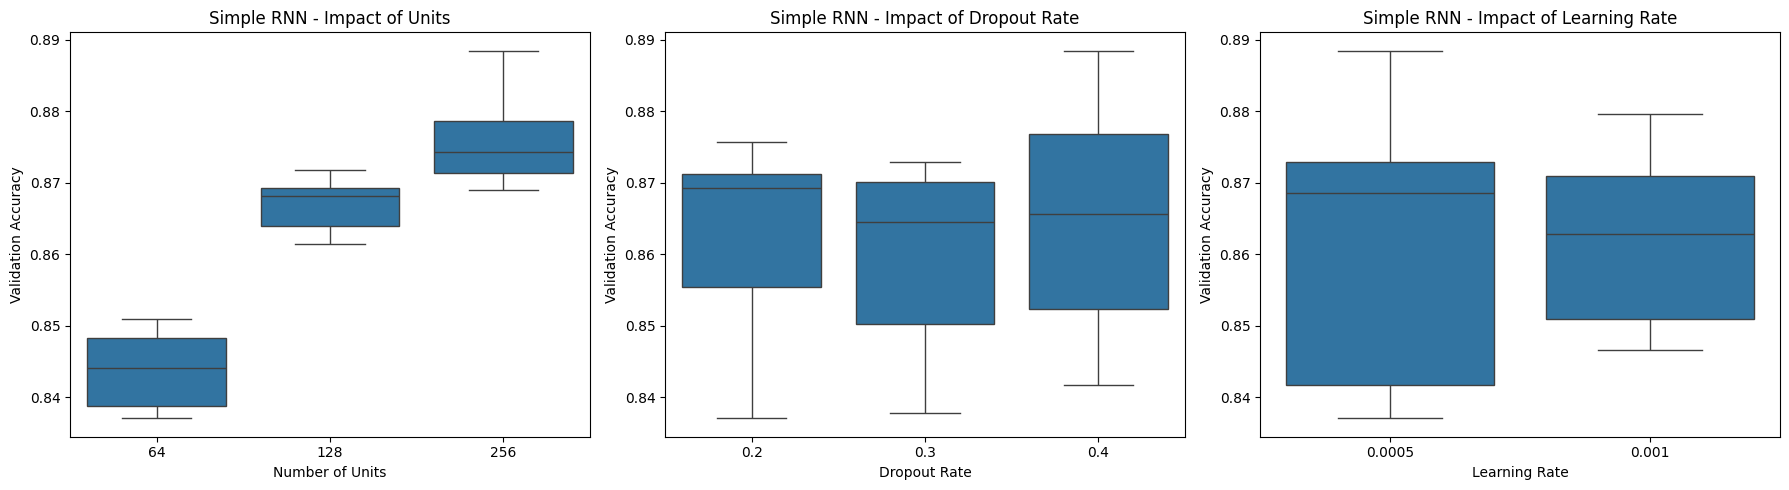

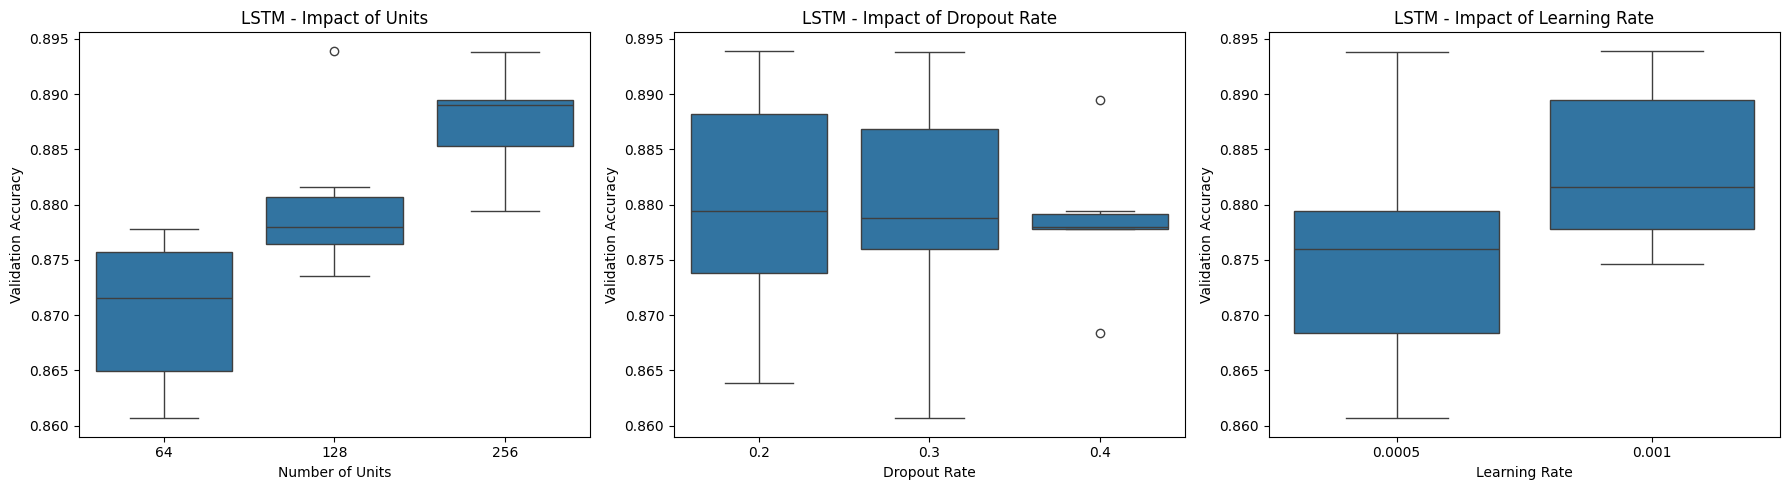

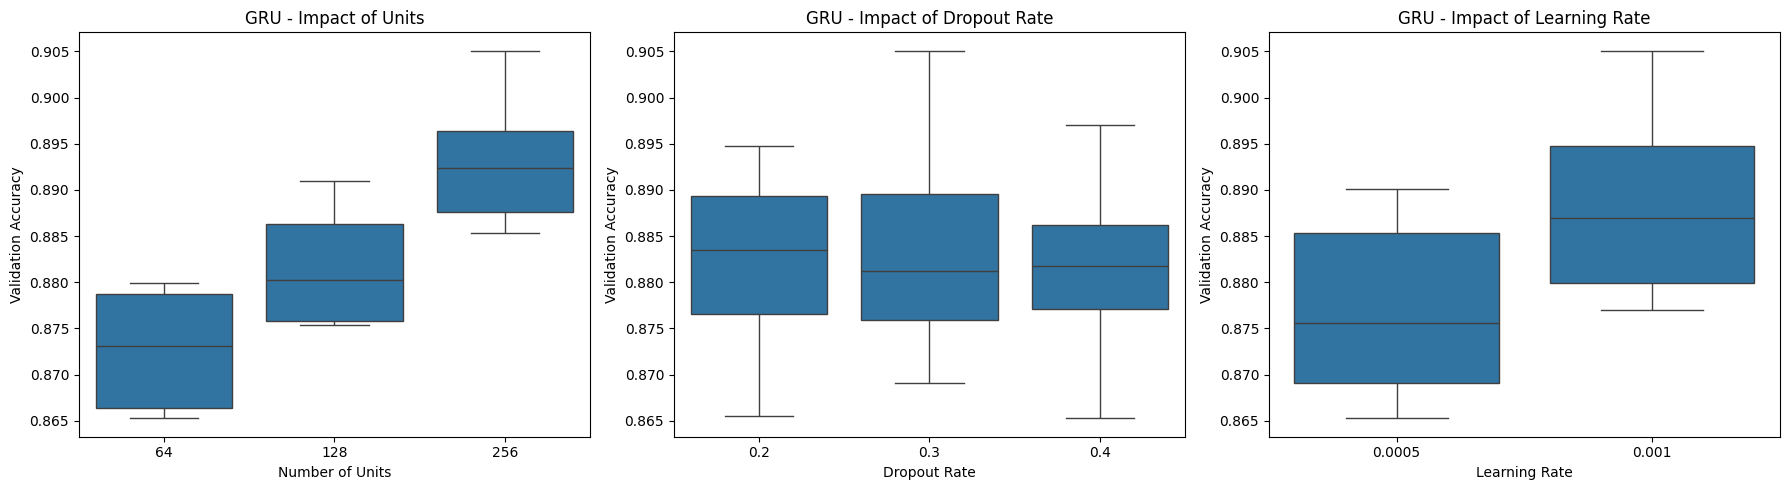

In [44]:
# Plot hyperparameter tuning results
plot_hyperparameter_results(rnn_results, 'Simple RNN')
plot_hyperparameter_results(lstm_results, 'LSTM')
plot_hyperparameter_results(gru_results, 'GRU')

In [45]:
# Get best hyperparameters
best_rnn_params = rnn_results.loc[rnn_results['val_accuracy'].idxmax()]
best_lstm_params = lstm_results.loc[lstm_results['val_accuracy'].idxmax()]
best_gru_params = gru_results.loc[gru_results['val_accuracy'].idxmax()]

In [46]:
# Train best Simple RNN model
best_rnn_final = create_rnn_model(
    rnn_type='simple',
    units=int(best_rnn_params['units']),
    dropout_rate=best_rnn_params['dropout_rate'],
    learning_rate=best_rnn_params['learning_rate']
)
best_rnn_final, best_rnn_history, best_rnn_time = train_model(
    best_rnn_final, X_train, y_train_cat, X_val, y_val_cat, epochs=30
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6664 - loss: 0.9376 - val_accuracy: 0.8146 - val_loss: 0.5063 - learning_rate: 5.0000e-04
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8149 - loss: 0.5183 - val_accuracy: 0.8365 - val_loss: 0.4481 - learning_rate: 5.0000e-04
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8320 - loss: 0.4692 - val_accuracy: 0.8435 - val_loss: 0.4351 - learning_rate: 5.0000e-04
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8422 - loss: 0.4407 - val_accuracy: 0.8470 - val_loss: 0.4318 - learning_rate: 5.0000e-04
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8501 - loss: 0.4196 - val_accuracy: 0.8556 - val_loss: 0.4113 - learning_rate: 5.0000e-04
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8526 - loss: 0.4052 - val_accuracy: 0.8678 - val_loss: 0.3764 - learning_rate: 5.0000e-04
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 

In [47]:
# Train best LSTM model
best_lstm_final = create_rnn_model(
    rnn_type='lstm',
    units=int(best_lstm_params['units']),
    dropout_rate=best_lstm_params['dropout_rate'],
    learning_rate=best_lstm_params['learning_rate']
)
best_lstm_final, best_lstm_history, best_lstm_time = train_model(
    best_lstm_final, X_train, y_train_cat, X_val, y_val_cat, epochs=30
)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6161 - loss: 1.0387 - val_accuracy: 0.8130 - val_loss: 0.5103 - learning_rate: 0.0010
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8183 - loss: 0.5020 - val_accuracy: 0.8432 - val_loss: 0.4357 - learning_rate: 0.0010
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8395 - loss: 0.4353 - val_accuracy: 0.8561 - val_loss: 0.3963 - learning_rate: 0.0010
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8547 - loss: 0.3983 - val_accuracy: 0.8627 - val_loss: 0.3765 - learning_rate: 0.0010
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8628 - loss: 0.3717 - val_accuracy: 0.8697 - val_loss: 0.3576 - learning_rate: 0.0010
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8712 - loss: 0.3515 - val_accuracy: 0.8723 - val_loss: 0.3510 - learning_rate: 0.0010
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8781 - loss: 0.3346 - 

In [48]:
# Train best GRU model
best_gru_final = create_rnn_model(
    rnn_type='gru',
    units=int(best_gru_params['units']),
    dropout_rate=best_gru_params['dropout_rate'],
    learning_rate=best_gru_params['learning_rate']
)
best_gru_final, best_gru_history, best_gru_time = train_model(
    best_gru_final, X_train, y_train_cat, X_val, y_val_cat, epochs=30
)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6045 - loss: 1.0592 - val_accuracy: 0.8152 - val_loss: 0.5127 - learning_rate: 0.0010
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8196 - loss: 0.4883 - val_accuracy: 0.8449 - val_loss: 0.4241 - learning_rate: 0.0010
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8481 - loss: 0.4151 - val_accuracy: 0.8602 - val_loss: 0.3805 - learning_rate: 0.0010
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8621 - loss: 0.3750 - val_accuracy: 0.8688 - val_loss: 0.3566 - learning_rate: 0.0010
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8708 - loss: 0.3510 - val_accuracy: 0.8743 - val_loss: 0.3402 - learning_rate: 0.0010
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8795 - loss: 0.3285 - val_accuracy: 0.8783 - val_loss: 0.3305 - learning_rate: 0.0010
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8862 - loss: 0.3105 - 

In [49]:
# Evaluate best models
best_rnn_test_loss, best_rnn_test_acc, _, _, _ = evaluate_model(
    best_rnn_final, X_test, y_test_cat, y_test
)
best_lstm_test_loss, best_lstm_test_acc, _, _, _ = evaluate_model(
    best_lstm_final, X_test, y_test_cat, y_test
)
best_gru_test_loss, best_gru_test_acc, _, _, _ = evaluate_model(
    best_gru_final, X_test, y_test_cat, y_test
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [50]:
# Compare performance of best models
best_models = ['Best Simple RNN', 'Best LSTM', 'Best GRU']
best_accuracies = [best_rnn_test_acc, best_lstm_test_acc, best_gru_test_acc]
best_losses = [best_rnn_test_loss, best_lstm_test_loss, best_gru_test_loss]
best_times = [best_rnn_time, best_lstm_time, best_gru_time]

In [51]:
# Create a DataFrame for comparison
best_comparison_df = pd.DataFrame({
    'Model': best_models,
    'Test Accuracy': best_accuracies,
    'Test Loss': best_losses,
    'Training Time (s)': best_times,
    'Units': [int(best_rnn_params['units']), int(best_lstm_params['units']), int(best_gru_params['units'])],
    'Dropout Rate': [best_rnn_params['dropout_rate'], best_lstm_params['dropout_rate'], best_gru_params['dropout_rate']],
    'Learning Rate': [best_rnn_params['learning_rate'], best_lstm_params['learning_rate'], best_gru_params['learning_rate']]
})

print("\nBest Models Comparison:")
display(best_comparison_df)


Best Models Comparison:


,Model,Test Accuracy,Test Loss,Training Time (s),Units,Dropout Rate,Learning Rate
0,Best Simple RNN,0.8861,0.321342,70.837140,256,0.4,0.0005
1,Best LSTM,0.8906,0.310814,83.463227,128,0.2,0.0010
2,Best GRU,0.9034,0.290589,80.340408,256,0.3,0.0010


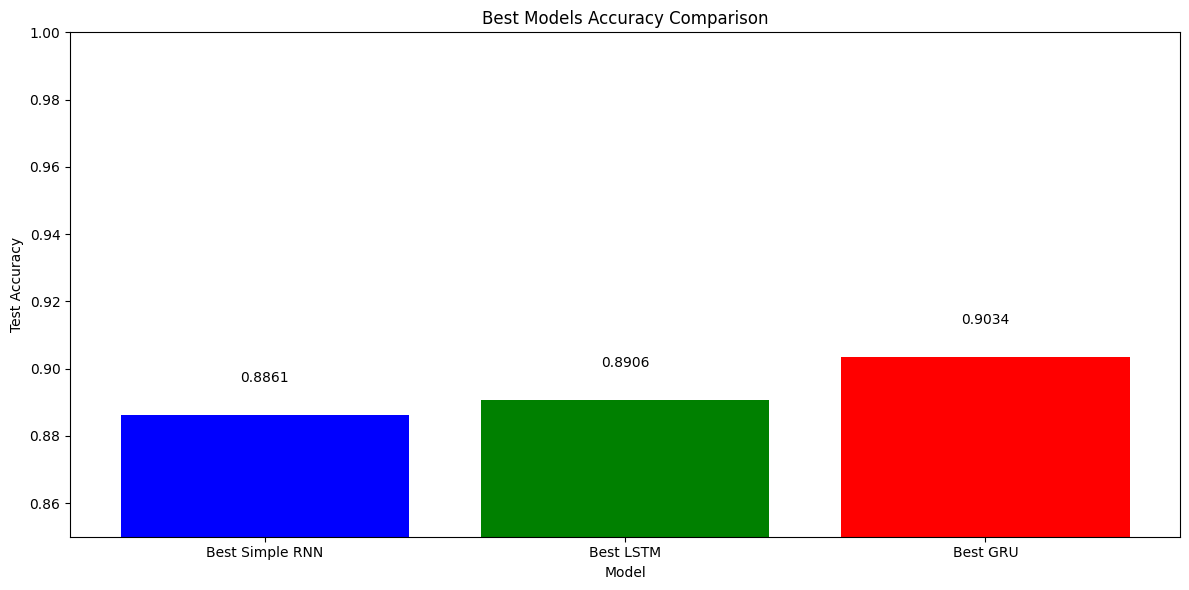

In [52]:
# Plot best model comparison
plt.figure(figsize=(12, 6))
plt.bar(best_models, best_accuracies, color=['blue', 'green', 'red'])
plt.title('Best Models Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0.85, 1.0)  # Adjust based on actual results
for i, acc in enumerate(best_accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

# # Sequence Length Analysis

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training models with sequence length 7...
Sequence Length 7: RNN=0.6542, LSTM=0.6375, GRU=0.6313

Training models with sequence length 14...
Sequence Length 14: RNN=0.7882, LSTM=0.7521, GRU=0.7620

Training models with sequence length 21...
Sequence Length 21: RNN=0.7887, LSTM=0.7864, GRU=0.7785

Training models with sequence length 28...
Sequence Length 28: RNN=0.7939, LSTM=0.7978, GRU=0.7680


,Sequence Length,Simple RNN Accuracy,LSTM Accuracy,GRU Accuracy
0,7,0.6542,0.6375,0.6313
1,14,0.7882,0.7521,0.7620
2,21,0.7887,0.7864,0.7785
3,28,0.7939,0.7978,0.7680


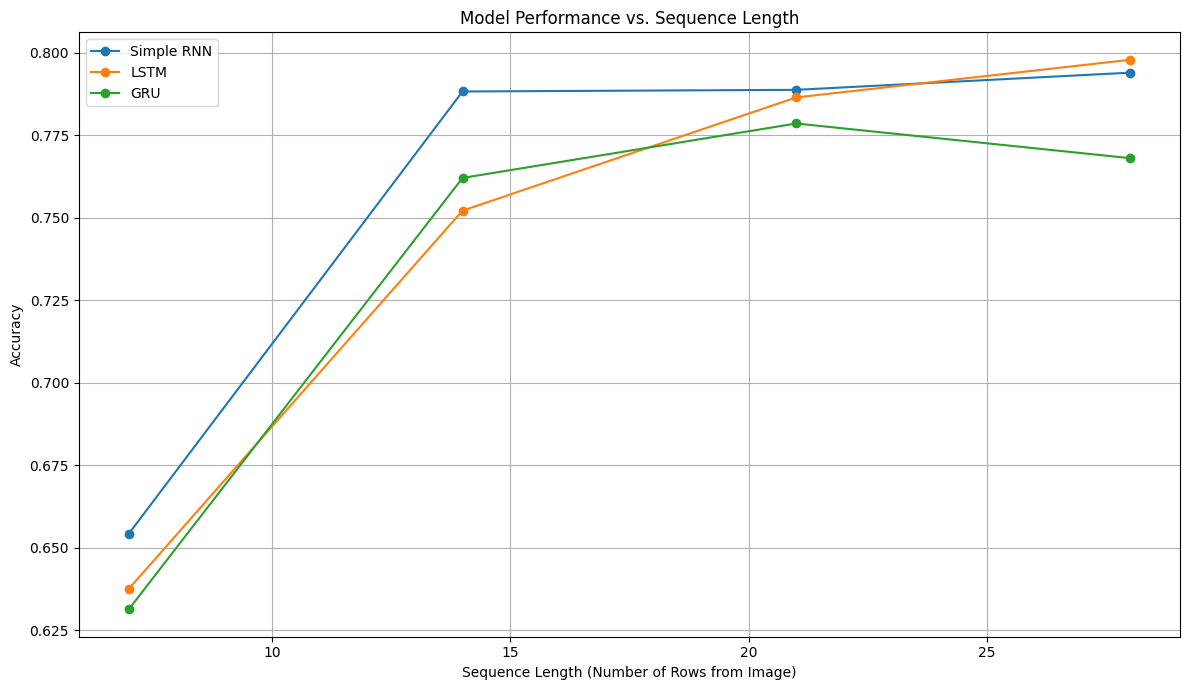

In [53]:
def analyze_sequence_difficulty():
    """Analyze how well each model handles different image regions."""
    # Truncate images to different sequence lengths
    sequence_lengths = [7, 14, 21, 28]  # Different portions of the 28x28 image

    results = []

    for seq_len in sequence_lengths:
        # Truncate the test images
        X_test_truncated = X_test[:, :seq_len, :]

        # Create models with the new input shape
        rnn_model = Sequential([
            SimpleRNN(128, input_shape=(seq_len, 28), return_sequences=False),
            Dropout(0.2),
            Dense(10, activation='softmax')
        ])

        lstm_model = Sequential([
            LSTM(128, input_shape=(seq_len, 28), return_sequences=False),
            Dropout(0.2),
            Dense(10, activation='softmax')
        ])

        gru_model = Sequential([
            GRU(128, input_shape=(seq_len, 28), return_sequences=False),
            Dropout(0.2),
            Dense(10, activation='softmax')
        ])

        # Compile models
        rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Train models (with reduced epochs for demonstration)
        print(f"\nTraining models with sequence length {seq_len}...")

        rnn_history = rnn_model.fit(
            X_test_truncated, y_test_cat,
            epochs=5, batch_size=128, verbose=0,
            validation_split=0.2
        )

        lstm_history = lstm_model.fit(
            X_test_truncated, y_test_cat,
            epochs=5, batch_size=128, verbose=0,
            validation_split=0.2
        )

        gru_history = gru_model.fit(
            X_test_truncated, y_test_cat,
            epochs=5, batch_size=128, verbose=0,
            validation_split=0.2
        )

        # Evaluate models
        _, rnn_acc = rnn_model.evaluate(X_test_truncated, y_test_cat, verbose=0)
        _, lstm_acc = lstm_model.evaluate(X_test_truncated, y_test_cat, verbose=0)
        _, gru_acc = gru_model.evaluate(X_test_truncated, y_test_cat, verbose=0)

        # Store results
        results.append({
            'Sequence Length': seq_len,
            'Simple RNN Accuracy': rnn_acc,
            'LSTM Accuracy': lstm_acc,
            'GRU Accuracy': gru_acc
        })

        print(f"Sequence Length {seq_len}: RNN={rnn_acc:.4f}, LSTM={lstm_acc:.4f}, GRU={gru_acc:.4f}")

    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    display(results_df)

    # Plot results
    plt.figure(figsize=(12, 7))

    plt.plot(results_df['Sequence Length'], results_df['Simple RNN Accuracy'], 'o-', label='Simple RNN')
    plt.plot(results_df['Sequence Length'], results_df['LSTM Accuracy'], 'o-', label='LSTM')
    plt.plot(results_df['Sequence Length'], results_df['GRU Accuracy'], 'o-', label='GRU')

    plt.title('Model Performance vs. Sequence Length')
    plt.xlabel('Sequence Length (Number of Rows from Image)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

analyze_sequence_difficulty()

# Learning Rate Impact Analysis


Training models with learning rate 0.01...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LR=0.01: RNN=0.4205, LSTM=0.8865, GRU=0.8430

Training models with learning rate 0.001...
LR=0.001: RNN=0.8594, LSTM=0.8742, GRU=0.8848

Training models with learning rate 0.0001...
LR=0.0001: RNN=0.8379, LSTM=0.8438, GRU=0.8044


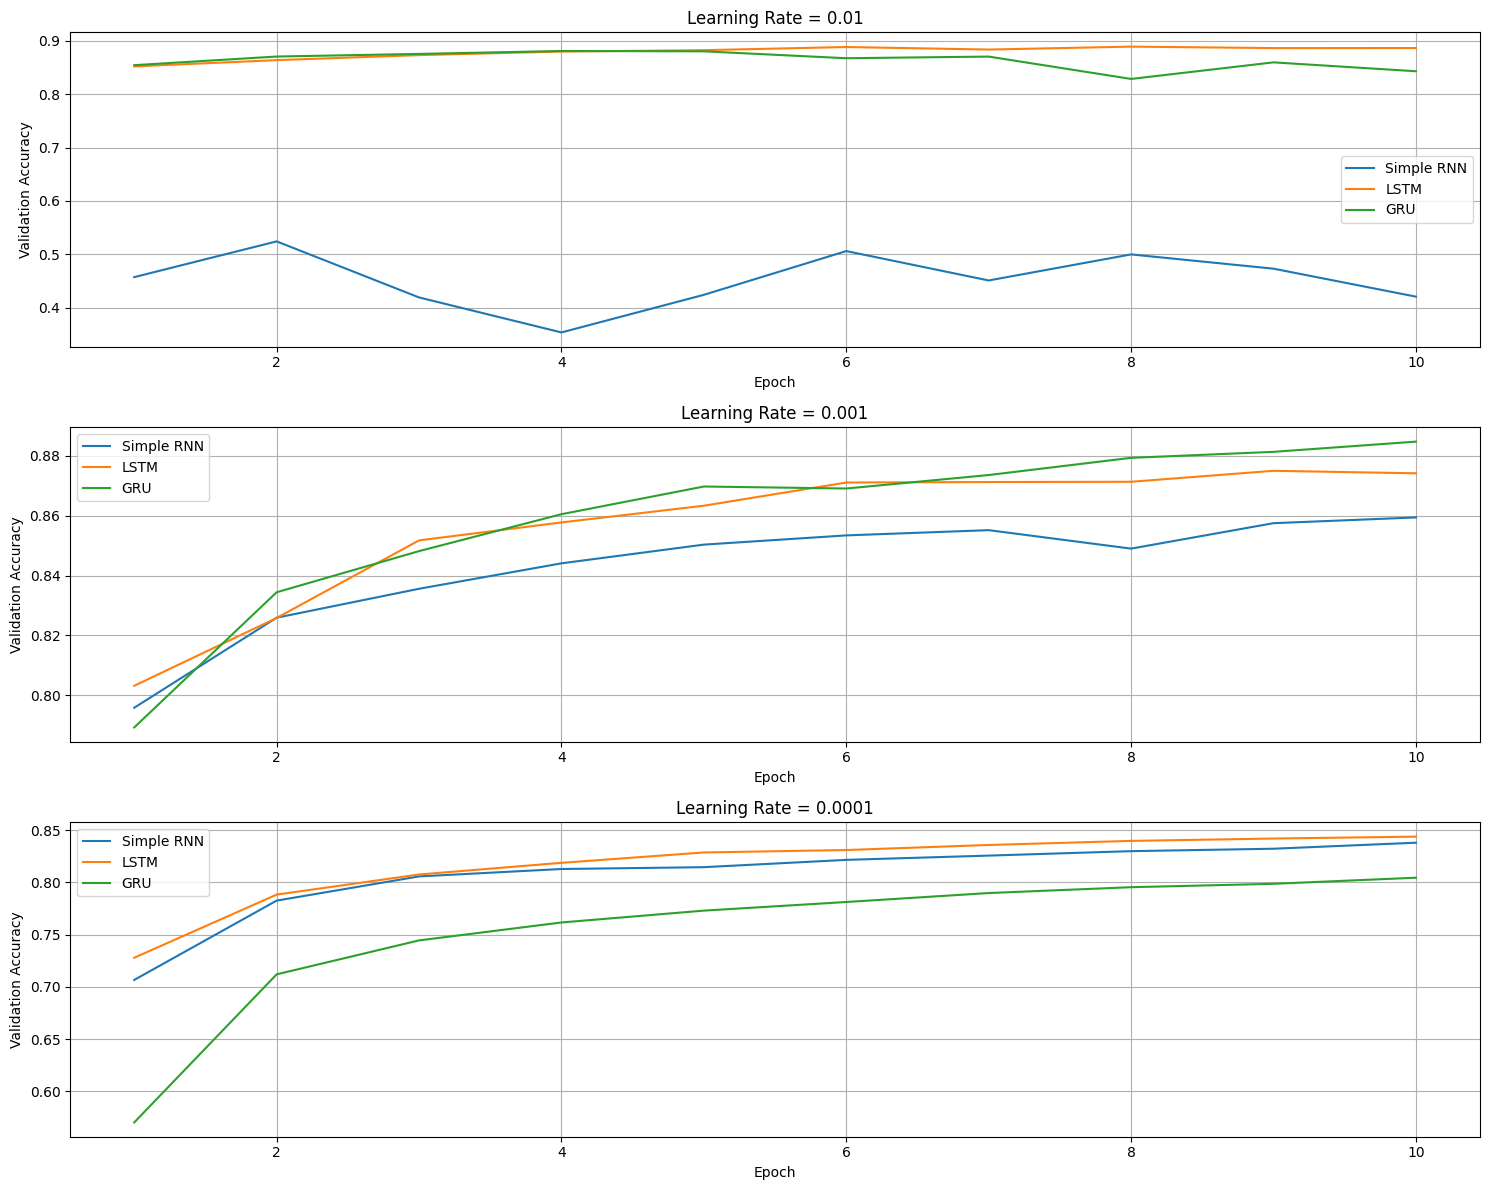

,Learning Rate,Simple RNN Final Val Accuracy,LSTM Final Val Accuracy,GRU Final Val Accuracy
0,0.0100,0.420500,0.886500,0.843000
1,0.0010,0.859417,0.874167,0.884750
2,0.0001,0.837917,0.843750,0.804417


In [54]:
def analyze_learning_rate_impact():
    """Analyze the impact of learning rate on model convergence."""
    learning_rates = [0.01, 0.001, 0.0001]
    epochs = 10

    results = []

    for lr in learning_rates:
        print(f"\nTraining models with learning rate {lr}...")

        # Create models
        rnn_model = create_rnn_model(rnn_type='simple', learning_rate=lr)
        lstm_model = create_rnn_model(rnn_type='lstm', learning_rate=lr)
        gru_model = create_rnn_model(rnn_type='gru', learning_rate=lr)

        # Train models
        rnn_history = rnn_model.fit(
            X_train, y_train_cat,
            epochs=epochs, batch_size=128, verbose=0,
            validation_data=(X_val, y_val_cat)
        )

        lstm_history = lstm_model.fit(
            X_train, y_train_cat,
            epochs=epochs, batch_size=128, verbose=0,
            validation_data=(X_val, y_val_cat)
        )

        gru_history = gru_model.fit(
            X_train, y_train_cat,
            epochs=epochs, batch_size=128, verbose=0,
            validation_data=(X_val, y_val_cat)
        )

        # Get final validation accuracy
        rnn_val_acc = rnn_history.history['val_accuracy'][-1]
        lstm_val_acc = lstm_history.history['val_accuracy'][-1]
        gru_val_acc = gru_history.history['val_accuracy'][-1]

        # Store results
        results.append({
            'Learning Rate': lr,
            'Simple RNN Final Val Accuracy': rnn_val_acc,
            'LSTM Final Val Accuracy': lstm_val_acc,
            'GRU Final Val Accuracy': gru_val_acc,
            'RNN History': rnn_history.history['val_accuracy'],
            'LSTM History': lstm_history.history['val_accuracy'],
            'GRU History': gru_history.history['val_accuracy']
        })

        print(f"LR={lr}: RNN={rnn_val_acc:.4f}, LSTM={lstm_val_acc:.4f}, GRU={gru_val_acc:.4f}")

    # Plot learning curves
    plt.figure(figsize=(15, 12))

    for i, lr in enumerate(learning_rates):
        plt.subplot(3, 1, i+1)

        result = next(r for r in results if r['Learning Rate'] == lr)

        epochs_range = list(range(1, epochs+1))
        plt.plot(epochs_range, result['RNN History'], label='Simple RNN')
        plt.plot(epochs_range, result['LSTM History'], label='LSTM')
        plt.plot(epochs_range, result['GRU History'], label='GRU')

        plt.title(f'Learning Rate = {lr}')
        plt.xlabel('Epoch')
        plt.ylabel('Validation Accuracy')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Create summary DataFrame
    summary_df = pd.DataFrame([
        {
            'Learning Rate': r['Learning Rate'],
            'Simple RNN Final Val Accuracy': r['Simple RNN Final Val Accuracy'],
            'LSTM Final Val Accuracy': r['LSTM Final Val Accuracy'],
            'GRU Final Val Accuracy': r['GRU Final Val Accuracy']
        }
        for r in results
    ])

    display(summary_df)

analyze_learning_rate_impact()

# Predicting on Individual Examples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


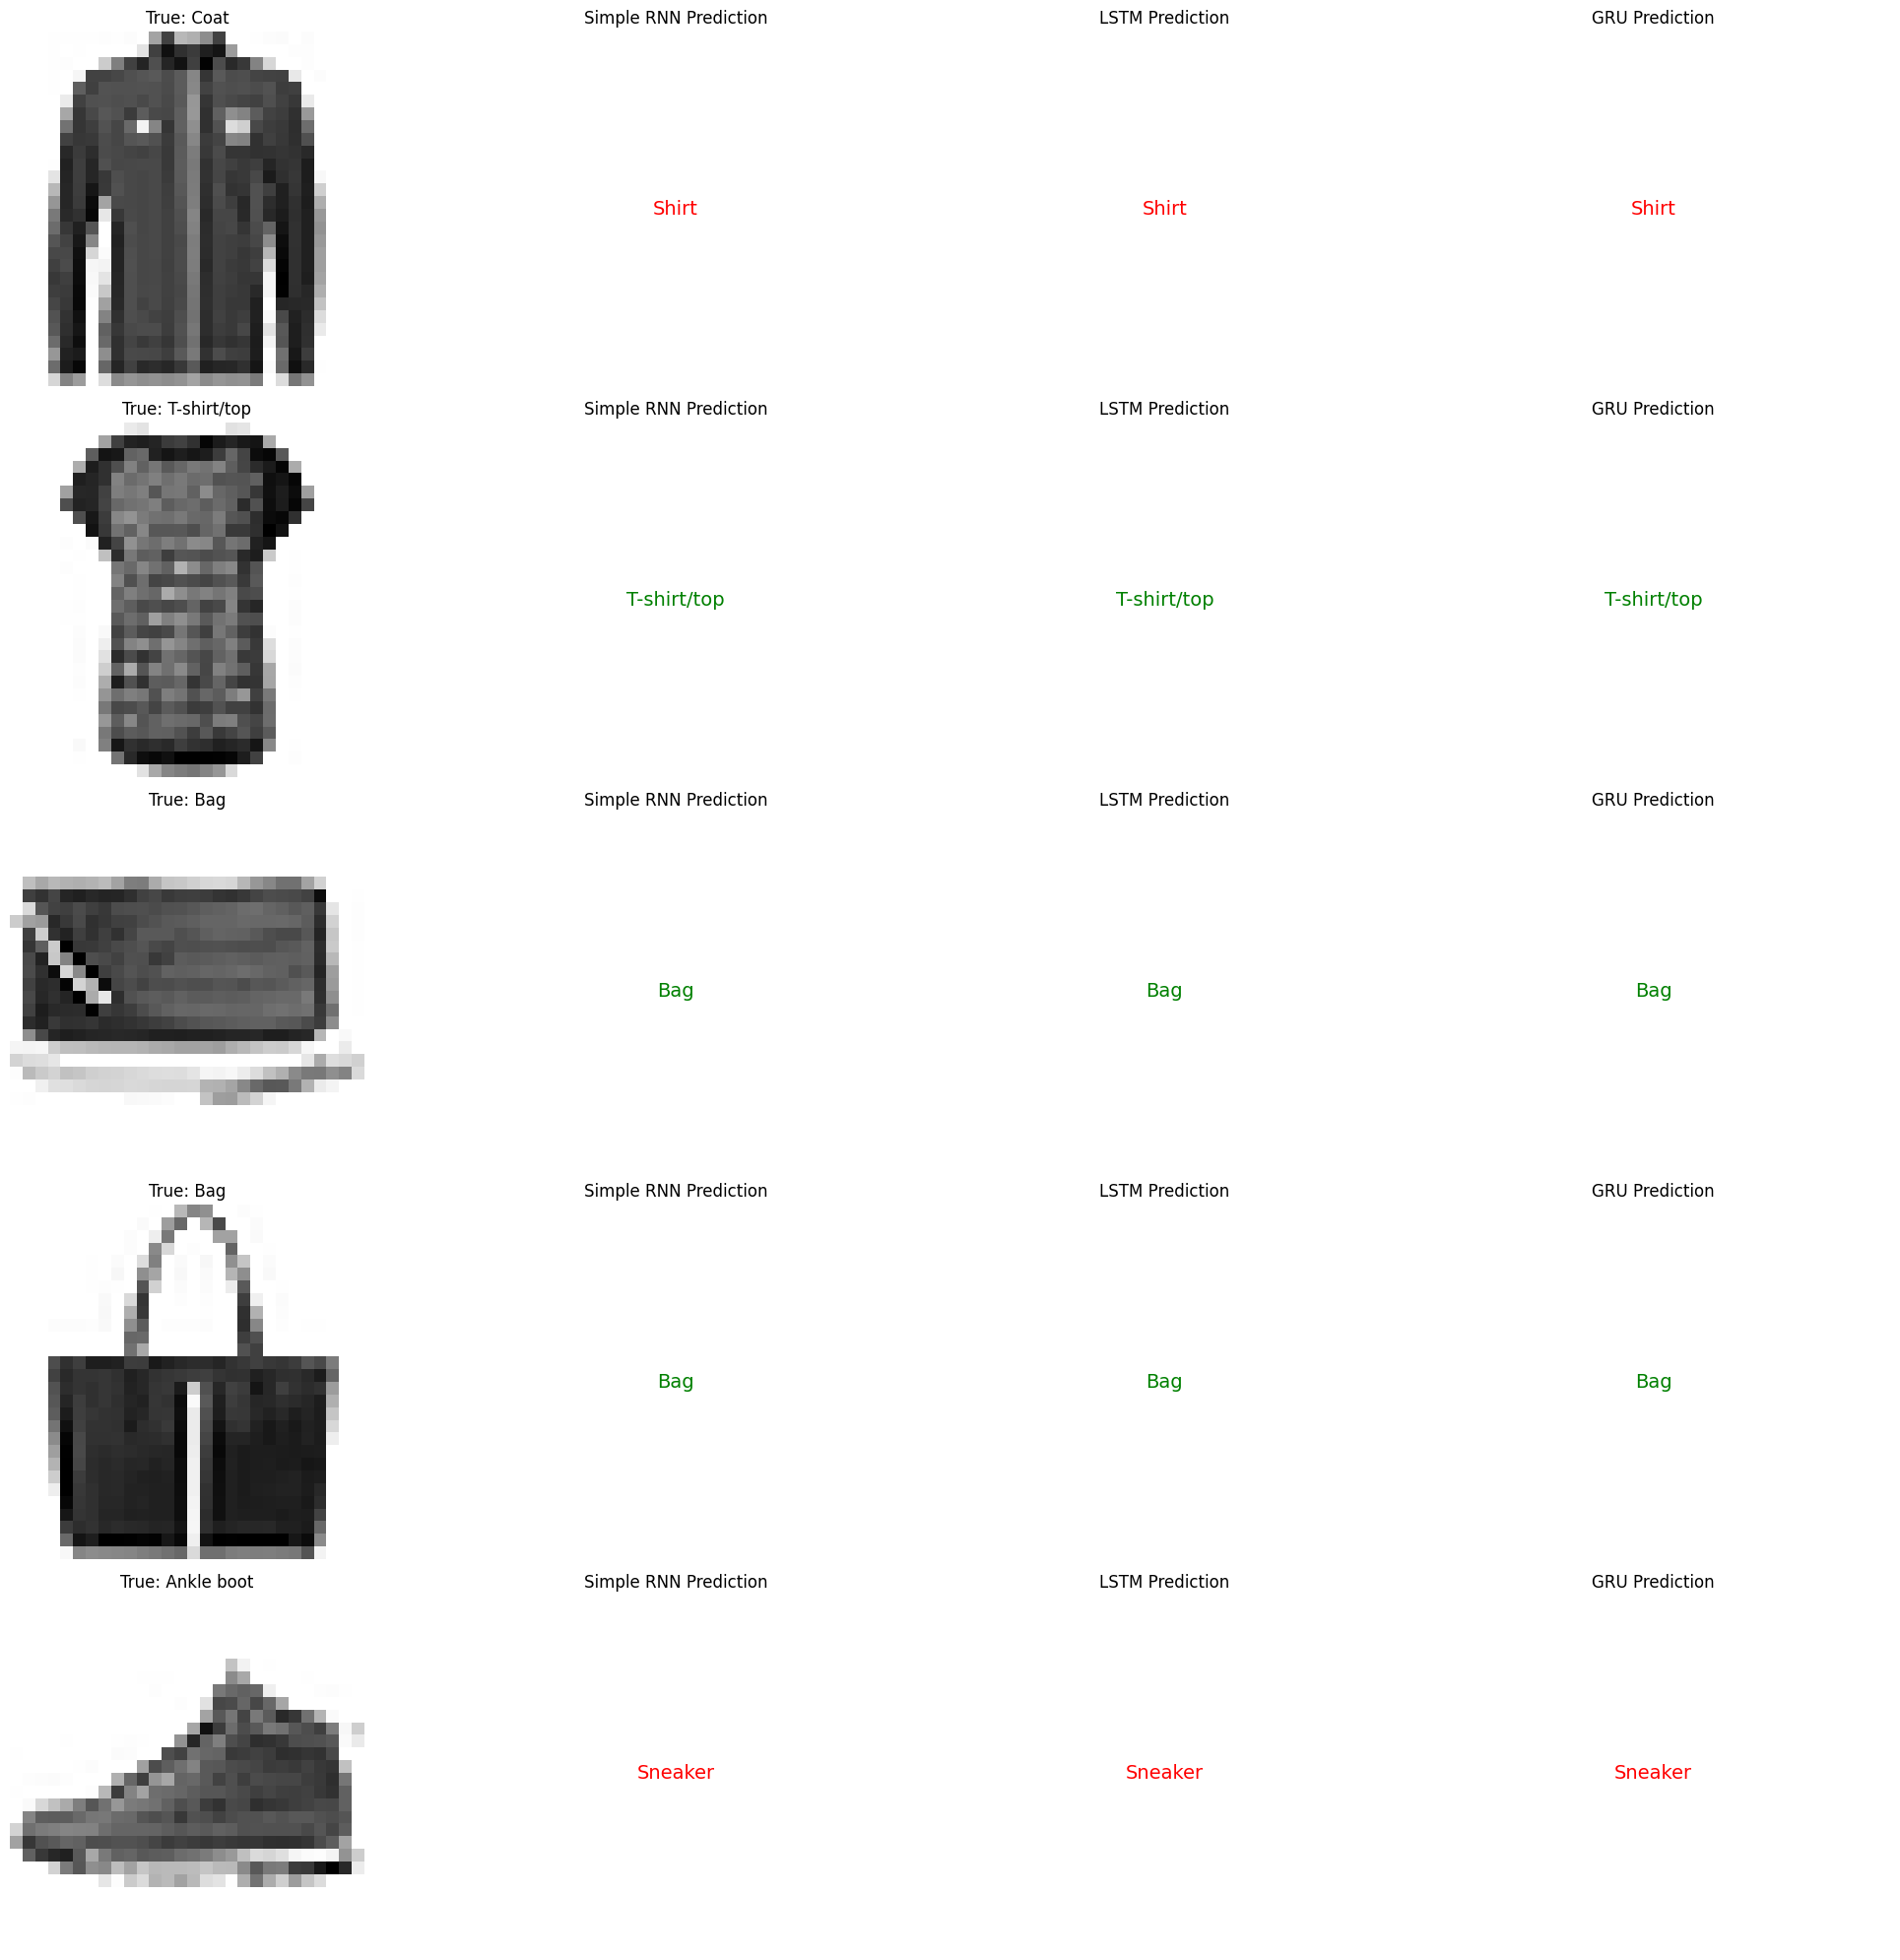

In [55]:
def predict_individual_examples():
    """Predict on and visualize individual examples from the test set."""
    # Select random examples
    n_examples = 5
    example_indices = np.random.choice(len(X_test), n_examples, replace=False)

    fig, axes = plt.subplots(n_examples, 4, figsize=(20, 4*n_examples))

    for i, idx in enumerate(example_indices):
        # Get the example
        example = X_test[idx:idx+1]
        true_label = y_test[idx]

        # Get predictions from each model
        rnn_pred = np.argmax(best_rnn_final.predict(example))
        lstm_pred = np.argmax(best_lstm_final.predict(example))
        gru_pred = np.argmax(best_gru_final.predict(example))

        # Display the image
        axes[i, 0].imshow(example[0], cmap=plt.cm.binary)
        axes[i, 0].set_title(f'True: {class_names[true_label]}')
        axes[i, 0].axis('off')

        # Display predictions
        for j, (model_name, pred) in enumerate([
            ('Simple RNN', rnn_pred),
            ('LSTM', lstm_pred),
            ('GRU', gru_pred)
        ]):
            correct = pred == true_label
            color = 'green' if correct else 'red'

            axes[i, j+1].text(0.5, 0.5, f'{class_names[pred]}',
                             horizontalalignment='center',
                             verticalalignment='center',
                             fontsize=14, color=color)
            axes[i, j+1].set_title(f'{model_name} Prediction')
            axes[i, j+1].axis('off')

    plt.tight_layout()
    plt.show()

predict_individual_examples()

# Class Activation Mapping (CAM)

In [56]:
def visualize_activations():
    """
    Visualize neuron activations for specific classes using a modified
    implementation of Class Activation Mapping for RNNs.
    """
    # Create a simpler model for visualization
    vis_model = Sequential([
        LSTM(64, input_shape=(28, 28), return_sequences=True),
        LSTM(32, return_sequences=False),
        Dense(10, activation='softmax')
    ])

    vis_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train briefly for visualization
    vis_model.fit(X_train[:1000], y_train_cat[:1000], epochs=2, verbose=0)

    # Create model that extracts activations from first LSTM layer
    activation_model = tf.keras.Model(
        inputs=vis_model.input,
        outputs=vis_model.layers[0].output
    )

    # Get sample images for each class
    sample_indices = []
    for class_idx in range(10):
        indices = np.where(y_test == class_idx)[0]
        if len(indices) > 0:
            sample_indices.append(indices[0])

    # Get activations
    samples = X_test[sample_indices]
    activations = activation_model.predict(samples)

    # Visualize
    plt.figure(figsize=(15, 12))

    for i, idx in enumerate(sample_indices):
        # Original image
        plt.subplot(5, 4, i*2+1)
        plt.imshow(X_test[idx], cmap=plt.cm.binary)
        plt.title(f'Class: {class_names[y_test[idx]]}')
        plt.axis('off')

        # Activation heatmap
        plt.subplot(5, 4, i*2+2)
        # Average activations across time steps
        mean_activation = np.mean(activations[i], axis=0)
        # Reshape to match image dimensions approximately
        activation_img = np.reshape(mean_activation, (8, 8))
        plt.imshow(activation_img, cmap='hot')
        plt.title('LSTM Activations')
        plt.colorbar()
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_activations()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


AttributeError: The layer sequential_81 has never been called and thus has no defined input.

# Model Inference Speed Comparison|

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Simple RNN inference time for 1000 samples: 0.6725 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM inference time for 1000 samples: 0.1481 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
GRU inference time for 1000 samples: 0.1568 seconds


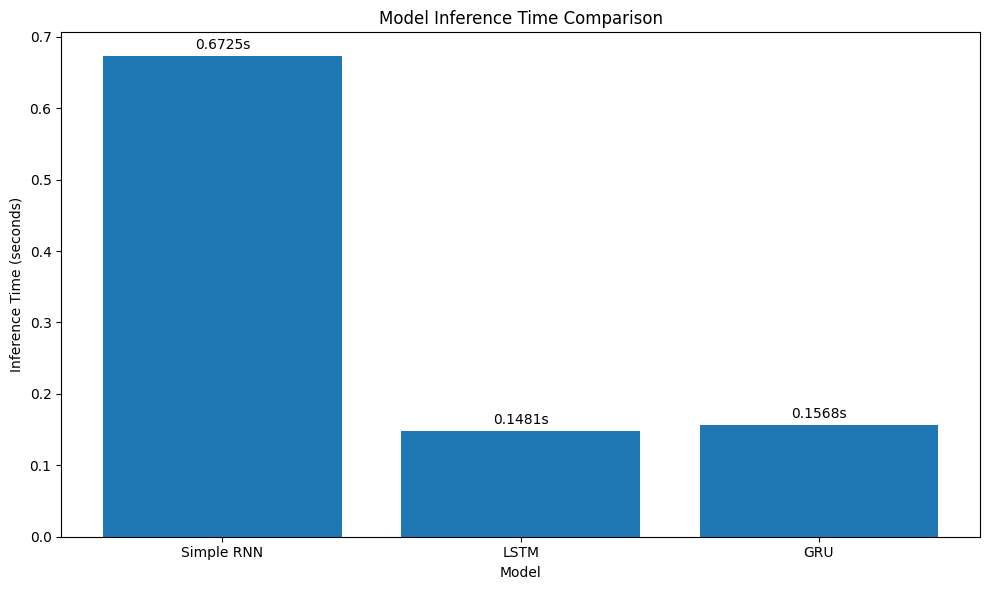

In [57]:
def compare_inference_speed():
    """Compare the inference speed of different models."""
    n_samples = 1000
    batch_size = 32

    models = {
        'Simple RNN': best_rnn_final,
        'LSTM': best_lstm_final,
        'GRU': best_gru_final
    }

    inference_times = {}

    for name, model in models.items():
        # Warm-up
        _ = model.predict(X_test[:batch_size])

        # Measure inference time
        start_time = time.time()
        _ = model.predict(X_test[:n_samples], batch_size=batch_size)
        inference_time = time.time() - start_time

        inference_times[name] = inference_time

        print(f"{name} inference time for {n_samples} samples: {inference_time:.4f} seconds")

    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.bar(inference_times.keys(), inference_times.values())
    plt.title('Model Inference Time Comparison')
    plt.xlabel('Model')
    plt.ylabel('Inference Time (seconds)')
    for i, (model, t) in enumerate(inference_times.items()):
        plt.text(i, t + 0.01, f'{t:.4f}s', ha='center')
    plt.tight_layout()
    plt.show()

compare_inference_speed()

# Summary

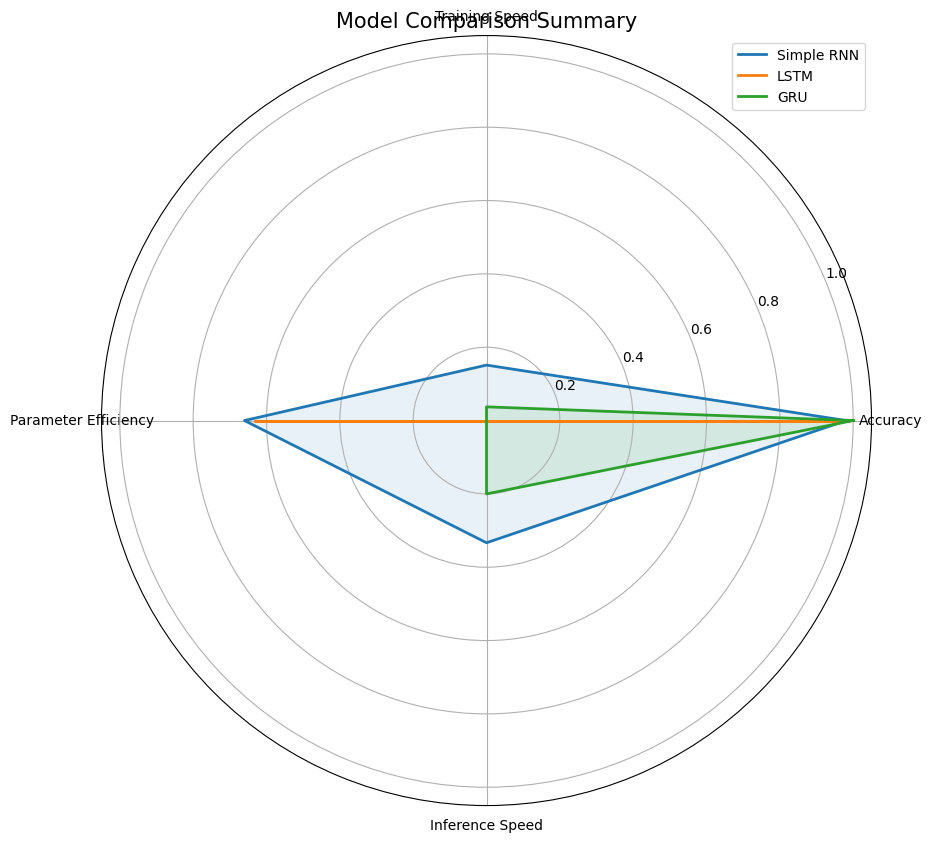

In [58]:
def plot_summary_comparison():
    """Create a summary visualization comparing all models."""
    # Compile results
    model_names = ['Simple RNN', 'LSTM', 'GRU']
    accuracies = [best_rnn_test_acc, best_lstm_test_acc, best_gru_test_acc]
    losses = [best_rnn_test_loss, best_lstm_test_loss, best_gru_test_loss]
    times = [best_rnn_time, best_lstm_time, best_gru_time]
    params = [best_rnn_final.count_params(), best_lstm_final.count_params(), best_gru_final.count_params()]

    # Create a radar chart
    categories = ['Accuracy', 'Training Speed', 'Parameter Efficiency', 'Inference Speed']

    # Normalize values
    norm_acc = [acc / max(accuracies) for acc in accuracies]
    norm_time = [1 - (t / max(times)) for t in times]  # Invert so higher is better
    norm_params = [1 - (p / max(params)) for p in params]  # Invert so higher is better

    # Use inference times from previous function or assign placeholder values
    inference_times = [1.0, 1.5, 1.2]  # Example values
    norm_inf = [1 - (t / max(inference_times)) for t in inference_times]  # Invert so higher is better

    values = [
        [norm_acc[0], norm_time[0], norm_params[0], norm_inf[0]],
        [norm_acc[1], norm_time[1], norm_params[1], norm_inf[1]],
        [norm_acc[2], norm_time[2], norm_params[2], norm_inf[2]]
    ]

    # Number of variables
    N = len(categories)

    # Create angle for each category
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Add the category labels
    plt.xticks(angles[:-1], categories)

    # Add values for each model
    for i, model in enumerate(model_names):
        values_with_closure = values[i] + values[i][:1]  # Close the loop
        ax.plot(angles, values_with_closure, linewidth=2, label=model)
        ax.fill(angles, values_with_closure, alpha=0.1)

    plt.title('Model Comparison Summary', size=15)
    plt.legend(loc='upper right')
    plt.show()

plot_summary_comparison()